In [1]:
#import the necessary modules 
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import scipy
import sklearn
import itertools 
from itertools import cycle 
import os.path as op
import timeit 
import json
import math

In [2]:
import multiprocessing as m_proc
m_proc.cpu_count()

4

In [3]:
# Import MDAnalysis
import MDAnalysis as mda
import statsmodels as stats
from MDAnalysis.analysis import distances, rdf

In [4]:
from polymer_MD_analysis import (pers_length, get_rg_pers_poly, bavg_pers_cnt, pos_bead_autocorr_RA,
                                 rouse_relax, zimm_relax_fit, zimm_relax_func, rh_block_avg, mean_sq_e2e, hydro_rad_poly,
                                obs_autocorr_RA, getPairStats, pair_regression, simple_regression_conf)

## 25 LGA: 75 EG PLGA-PEG/water simulations

### N = 8 25LGA:75EG in water

In [5]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n8_25LGA_75EG_wat = mda.Universe("n825LGA_75EG/n825LGA75EG_WAT.pdb", "n825LGA_75EG/NoWat_n825LGA_75EG.xtc")

In [6]:
n8_25LGA_75EG_wat.trajectory

<XTCReader n825LGA_75EG/NoWat_n825LGA_75EG.xtc with 18001 frames of 75 atoms>

In [7]:
len(n8_25LGA_75EG_wat.trajectory)

18001

In [8]:
#Select the polymer heavy atoms 
n8wat_25LGA75EG = n8_25LGA_75EG_wat.select_atoms("resname sPLG PLG bPLG bPEG PEG sPEG and not type H")

In [9]:
np.unique(n8wat_25LGA75EG.resids)

array([1, 2, 3, 4, 5, 6, 7, 8])

In [10]:
# Get cosine theta values at frame 0 
crv_n8wat_25LGA75EG = pers_length(n8wat_25LGA75EG,8)
crv_n8wat_25LGA75EG

array([[ 1.        ,  0.95173388,  0.93854951,  0.89502299,  0.84939377,
         0.78634836,  0.92008554],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ],
       [ 0.        , 17.87398144, 20.19062459, 26.48861665, 31.85420592,
        38.15444229, 23.0614094 ]])

### Mean squared end to end distance 

In [11]:
n8_mon = 8 
start = 0
end = 18001
trj_len = np.arange(18001)

In [12]:
eVec_n8wat25LGA75EG, e2edis_n8wat25LGA75EG = mean_sq_e2e(n8wat_25LGA75EG, n8_25LGA_75EG_wat, n8_mon, start, end)

(0.0, 5.0)

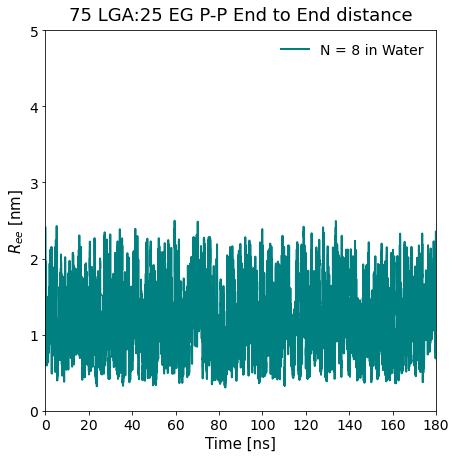

In [13]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P End to End distance', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{ee}$ [nm]', fontsize=15)
plt.plot(trj_len/100, e2edis_n8wat25LGA75EG[1]/10,linewidth=2, color='teal')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,5)

#### Ree Autocorrelation function

In [15]:
e2edis_n8wat25LGA75EG[1]

array([24.05399998, 22.75634249, 22.37988895, ..., 17.10559092,
       19.34881968, 18.01068846])

In [16]:
t_corr = 2000
window_shift = 20

In [17]:
ACn8wat25LGA75EG_Ree, eqvar_n8wat25LGA75EG = obs_autocorr_RA(e2edis_n8wat25LGA75EG[1],t_corr, window_shift,start,end)

No. of Samples: 801


In [18]:
ACn8wat25LGA75EG_Ree

array([[ 1.00000000e+00,  9.38907721e-01,  8.16116220e-01, ...,
        -1.27074835e-02,  2.39933315e-03,  4.43973654e-03],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [19]:
eqvar_n8wat25LGA75EG

18.83635291716101

In [20]:
ACn8wat25LGA75EG_sqRee, evsqRee_n8wat25LGA75EG = obs_autocorr_RA(e2edis_n8wat25LGA75EG[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [21]:
np.sqrt(evsqRee_n8wat25LGA75EG)

112.65842832647492

(-1.0, 1.0)

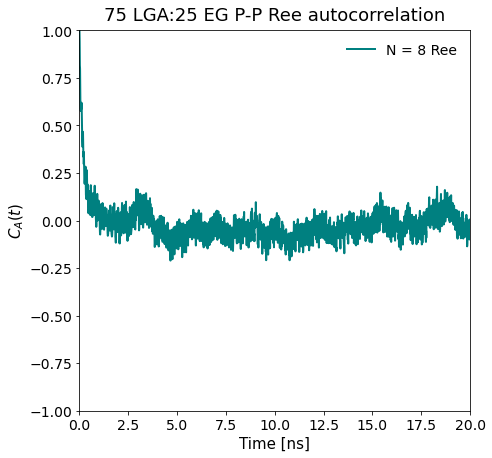

In [22]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Ree autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Ree[1]/100, ACn8wat25LGA75EG_Ree[0],linewidth=2, color='teal')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Ree'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

### Hydrodynamic Radius vs time

In [25]:
n8wat25LGA75EG_rh = hydro_rad_poly(n8wat_25LGA75EG, n8_25LGA_75EG_wat, n8_mon, start, end)

(0.0, 2.0)

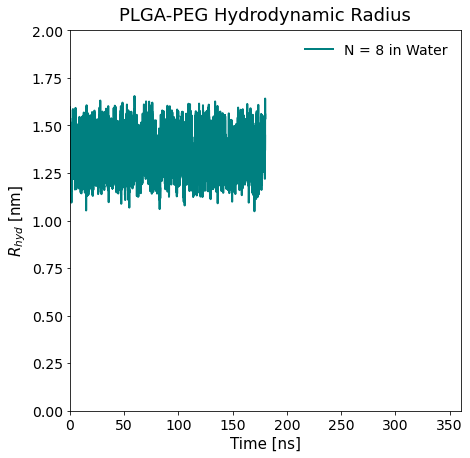

In [26]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA-PEG Hydrodynamic Radius', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{hyd}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n8wat25LGA75EG_rh/10,linewidth=2, color='teal')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,360)
plt.ylim(0,2)

#### Rh autocorrelation

In [27]:
ACn8wat25LGA75EG_Rh, eqvarRh_n8wat25LGA75EG = obs_autocorr_RA(n8wat25LGA75EG_rh,t_corr, window_shift,start,end)

No. of Samples: 801


In [28]:
ACn8wat25LGA75EG_Rh

array([[ 1.00000000e+00,  9.77060818e-01,  7.60014199e-01, ...,
        -1.64779051e-01,  5.71187030e-02, -3.53008405e-02],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [29]:
eqvarRh_n8wat25LGA75EG

1.067263698479735

(0.0, 20.0)

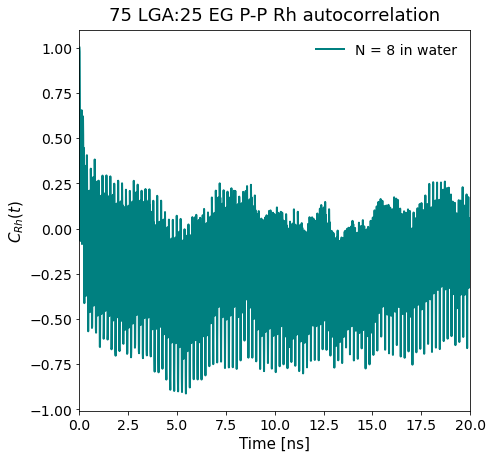

In [30]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Rh autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{Rh}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Rh[1]/100, ACn8wat25LGA75EG_Rh[0],linewidth=2, color='teal')
#plt.plot(A2n8plgapegwat_Ree[1]/100, ACn8plgapegwat_Ree[0],linewidth=2, color='r')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,20)
#plt.ylim(-0.2,1)

### Radius of Gyration vs. time N = 8 25LGA:75EG in water

In [31]:
n825LGA75EG_rgens_wat, cor_n825LGA75EG_wat, n825LGA75EG_cos_wat, rgwat_n825LGA75EG = get_rg_pers_poly(n8wat_25LGA75EG, n8_25LGA_75EG_wat,
                                                                                                  start,end)

In [32]:
n825LGA75EG_rgens_wat[0].shape

(18001,)

In [33]:
cor_n825LGA75EG_wat[3]

array([0., 1., 2., 3., 4., 5., 6.])

In [34]:
n825LGA75EG_cos_wat

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.95173388, 0.93461582, 0.94053199, ..., 0.92591199, 0.92904364,
        0.9354308 ],
       [0.93854951, 0.9017445 , 0.91645281, ..., 0.82890244, 0.82772057,
        0.85911458],
       ...,
       [0.84939377, 0.78189728, 0.81763492, ..., 0.60679267, 0.75241349,
        0.69115251],
       [0.78634836, 0.77559495, 0.84844057, ..., 0.58757611, 0.69001974,
        0.53346192],
       [0.92008554, 0.91643372, 0.90101496, ..., 0.52838634, 0.63564738,
        0.458693  ]])

In [35]:
rgwat_n825LGA75EG

5.721078264818212

In [36]:
n825LGA75EG_rgens_wat.shape

(2, 18001)

(0.2, 2.0)

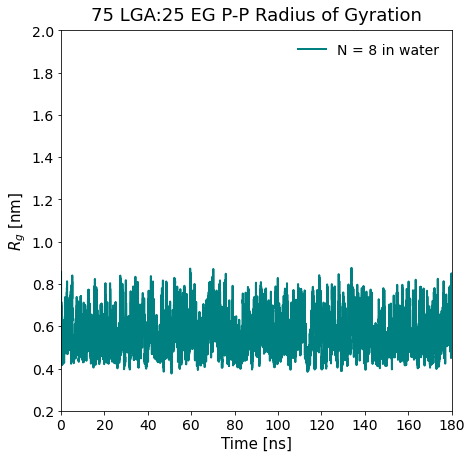

In [37]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n825LGA75EG_rgens_wat[0]/10,linewidth=2, color='teal')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

#### Rg Autocorrelation

In [38]:
ACn8wat25LGA75EG_Rg, eqvarRg_n8wat25LGA75EG = obs_autocorr_RA(n825LGA75EG_rgens_wat[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [39]:
ACn8wat25LGA75EG_Rg

array([[ 1.00000000e+00,  9.17460857e-01,  7.71845237e-01, ...,
        -8.49502812e-02, -4.05957102e-04, -6.35323344e-02],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [40]:
eqvarRg_n8wat25LGA75EG

0.8732455317613663

(-1.0, 1.0)

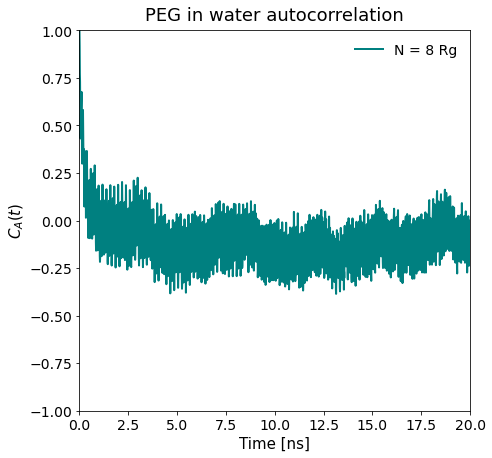

In [41]:
plt.figure(figsize=(7,7))
plt.title(r'PEG in water autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Rg[1]/100, ACn8wat25LGA75EG_Rg[0],linewidth=2, color='teal')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Rg'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

#### Get average COM distance, Arc length values

In [42]:
cb_n8plga = np.zeros(shape=(18001))
cb_n8pplinker = np.zeros(shape=(18001))
cb_n8peg = np.zeros(shape=(18001))
count = 0
for ts in n8_25LGA_75EG_wat.trajectory[0:18001]:
    # 1st two PLGA residues
    n8m1_plga = n8_25LGA_75EG_wat.select_atoms("resid 1")
    n8m2_plga = n8_25LGA_75EG_wat.select_atoms("resid 2")
    # PLGA-PEG linker
    n8pl_link = n8_25LGA_75EG_wat.select_atoms("resid 6")
    n8peg_link = n8_25LGA_75EG_wat.select_atoms("resid 7")
    # last two PEG residues 
    n8l1_peg = n8_25LGA_75EG_wat.select_atoms("resid 7")
    n8l2_peg = n8_25LGA_75EG_wat.select_atoms("resid 8")
    
    cb_n8plga[count] = mda.analysis.distances.distance_array(n8m1_plga.center_of_mass(), n8m2_plga.center_of_mass(), 
                                                   box=n8_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    cb_n8pplinker[count] = mda.analysis.distances.distance_array(n8pl_link.center_of_mass(), n8peg_link.center_of_mass(), 
                                                   box=n8_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    cb_n8peg[count] = mda.analysis.distances.distance_array(n8l1_peg.center_of_mass(), n8l2_peg.center_of_mass(), 
                                                   box=n8_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    count += 1
    

    

In [43]:
COM_n8pp = np.zeros(shape=(3,2))
COM_n8pp[0,0] = np.mean(cb_n8plga)
COM_n8pp[1,0] = np.mean(cb_n8pplinker)
COM_n8pp[2,0] = np.mean(cb_n8peg)
COM_n8pp[0,1] = np.std(cb_n8plga)
COM_n8pp[1,1] = np.std(cb_n8pplinker)
COM_n8pp[2,1] = np.std(cb_n8peg)
COM_n8pp

array([[5.47738021, 0.74673297],
       [3.25110047, 0.14751683],
       [3.24242453, 0.15288658]])

#### Correlation values at each arc length from the whole 360 ns trajectory, N = 8 25LGA:75EG/water

In [44]:
# x values
blen_n8pp = np.zeros(shape=n8_mon-1)
for i in range(n8_mon-1):
    if i < int(n8_mon-6):
        # PLGA contour length values
        if i == 0:
            blen_n8pp[i] = 0
        elif i != 0:
            blen_n8pp[i] = np.sum(blen_n8pp[i-1])+ COM_n8pp[0,0]    
    elif i == int(n8_mon-6):
        #PLGA-PEG linker length
        blen_n8pp[i] = np.sum(blen_n8pp[i-1]) + COM_n8pp[1,0]
    elif i == int(n8_mon-6):
    #    # PEG contour length values
        blen_n8pp[i] = np.sum(blen_n8pp[i-1]) + COM_n8pp[2,0]
        
blen_n8pp

array([0.        , 5.47738021, 8.72848068, 0.        , 0.        ,
       0.        , 0.        ])

In [45]:
# Error prop. into natural log std deviation
mk_n8ppwat = cor_n825LGA75EG_wat[1]/cor_n825LGA75EG_wat[0]
mk_n8ppwat

array([0.        , 0.00534812, 0.02096927, 0.05088623, 0.0914926 ,
       0.15668753, 0.24615953])

<ErrorbarContainer object of 3 artists>

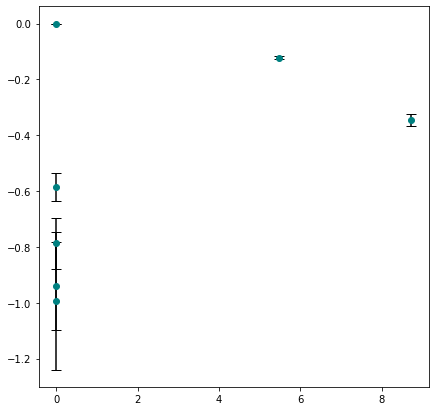

In [46]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_n8pp, np.log(cor_n825LGA75EG_wat[0]), yerr=mk_n8ppwat, color='teal', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [47]:
# All the points give the best fits for N = 6 peg in water
n8_blks25LGA75EG_wat , n825LGA75EG_lpwat = bavg_pers_cnt(5, n8wat_25LGA75EG, n8_25LGA_75EG_wat, blen_n8pp, 3, start, end)

0
3600
[1.         0.88436487 0.70501435 0.54853788 0.44474524 0.35909117
 0.30623083]
Lp [Angstroms]: 26.173662303279023
Error in Lp from fit [Angstroms], 95% CL : 108.71834479287276
R2 score: 0.9034506386414514
3600
7200
[1.         0.88883371 0.71424103 0.56842679 0.48650465 0.43962974
 0.40247234]
Lp [Angstroms]: 27.191519946526093
Error in Lp from fit [Angstroms], 95% CL : 113.54455242865964
R2 score: 0.9025250130019494
7200
10800
[1.         0.88570717 0.70665339 0.55093725 0.44929805 0.39573878
 0.38397632]
Lp [Angstroms]: 26.357982289394077
Error in Lp from fit [Angstroms], 95% CL : 110.32292314372549
R2 score: 0.9021106774942155
10800
14400
[1.         0.88397351 0.7066934  0.56187135 0.46266772 0.39948937
 0.40802816]
Lp [Angstroms]: 26.336081868533398
Error in Lp from fit [Angstroms], 95% CL : 107.86333290690281
R2 score: 0.9058795289995807
14400
18000
[1.         0.88383263 0.70417216 0.54911069 0.43336957 0.36531893
 0.35333881]
Lp [Angstroms]: 26.082104855866824
Error in 

In [48]:
n8_blks25LGA75EG_wat

{'Avg Hydrodynamic radius': array([13.385955544561627, 13.589696923550083, 13.366196776387884,
        13.469427013491151, 13.379027272638888], dtype=object),
 'Avg Radius of gyration': array([5.64084179, 5.88340425, 5.67133803, 5.79489308, 5.60984035]),
 'Avg Sq. radius of gyration': array([31.81909605, 34.61444559, 32.16407505, 33.5807858 , 31.47030872]),
 'Avg end to end distance': array([12.5573297 , 13.40009869, 12.4798336 , 13.47555664, 12.5636481 ]),
 'Avg Sq. end to end distance': array([157.68652909, 179.56264491, 155.74624668, 181.59062671,
        157.84525363]),
 'Avg persistence length': array([26.1736623 , 27.19151995, 26.35798229, 26.33608187, 26.08210486])}

In [49]:
n825LGA75EG_lpwat

array([[ 2.61736623e+01,  2.71915199e+01,  2.63579823e+01,
         2.63360819e+01,  2.60821049e+01],
       [ 1.08718345e+02,  1.13544552e+02,  1.10322923e+02,
         1.07863333e+02,  1.08124777e+02],
       [-3.82063461e-02, -3.67761715e-02, -3.79391711e-02,
        -3.79707204e-02, -3.83404639e-02],
       [ 6.07128122e-03,  5.68501131e-03,  6.07876758e-03,
         5.83009568e-03,  6.08993373e-03]])

In [50]:
n825LGA75EG_lpwat[2]

array([-0.03820635, -0.03677617, -0.03793917, -0.03797072, -0.03834046])

In [51]:
np.mean(n825LGA75EG_lpwat[3])

0.005951017902446297

#### Block averaged Radius of gyration and persistence length, N = 8 25LGA:75EG/water

In [52]:
np.mean(n8_blks25LGA75EG_wat["Avg Radius of gyration"])

5.720063498708132

In [53]:
np.std(n8_blks25LGA75EG_wat["Avg Radius of gyration"])

0.10303306466257259

In [54]:
rg25LGA75EG_olig_wat =  pd.DataFrame(data=n8_blks25LGA75EG_wat["Avg Radius of gyration"], columns=['$R_{g}$ [Angstrom] N = 8 25LGA:75EG water'])
rg25LGA75EG_olig_wat

,$R_{g}$ [Angstrom] N = 8 25LGA:75EG water
0,5.640842
1,5.883404
2,5.671338
3,5.794893
4,5.609840


In [55]:
pers_25LGA75EG_wat = pd.DataFrame(data=n8_blks25LGA75EG_wat["Avg persistence length"], columns=[r"$L_{p}$ [Angstrom] N = 8 25LGA:75EG water"])
pers_25LGA75EG_wat

,$L_{p}$ [Angstrom] N = 8 25LGA:75EG water
0,26.173662
1,27.191520
2,26.357982
3,26.336082
4,26.082105


### N = 12 25LGA:75EG in water

In [57]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n12_25LGA_75EG_wat = mda.Universe("n1225LGA_75EG/n1225LGA75EG_WAT.pdb", "n1225LGA_75EG/NoWat_n1225LGA_75EG.xtc")

In [58]:
n12_25LGA_75EG_wat.trajectory

<XTCReader n1225LGA_75EG/NoWat_n1225LGA_75EG.xtc with 18001 frames of 111 atoms>

In [59]:
len(n12_25LGA_75EG_wat.trajectory)

18001

In [60]:
#Select the polymer heavy atoms 
n12wat_25LGA75EG = n12_25LGA_75EG_wat.select_atoms("resname sPLG PLG bPLG bPEG PEG sPEG and not type H")

In [61]:
np.unique(n12wat_25LGA75EG.resids)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [62]:
# Get cosine theta values at frame 0 
crv_n12wat_25LGA75EG = pers_length(n12wat_25LGA75EG,12)
crv_n12wat_25LGA75EG

array([[ 1.        ,  0.94374661,  0.95546594,  0.92550811,  0.92098454,
         0.90566724,  0.88157954,  0.85622799,  0.80422915,  0.89324538,
         0.94959817],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        ],
       [ 0.        , 19.30941867, 17.16361737, 22.25490112, 22.92955803,
        25.08670087, 28.16650629, 31.1043368 , 36.46412468, 26.71606342,
        18.26846262]])

### Mean squared end to end distance 

In [63]:
n12_mon = 12 
start = 0
end = 18001
trj_len = np.arange(18001)

In [64]:
eVec_n12wat25LGA75EG, e2edis_n12wat25LGA75EG = mean_sq_e2e(n12wat_25LGA75EG, n12_25LGA_75EG_wat, n12_mon, start, end)

(0.0, 5.0)

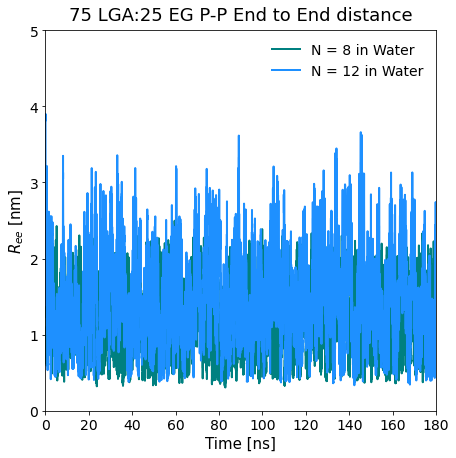

In [65]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P End to End distance', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{ee}$ [nm]', fontsize=15)
plt.plot(trj_len/100, e2edis_n8wat25LGA75EG[1]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, e2edis_n12wat25LGA75EG[1]/10,linewidth=2, color='dodgerblue')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,5)

#### Ree Autocorrelation function

In [66]:
e2edis_n12wat25LGA75EG[1]

array([38.28074897, 38.10238195, 39.01020291, ..., 15.74451728,
       21.79163826, 20.75166842])

In [ ]:
t_corr = 2000
window_shift = 20

In [67]:
ACn12wat25LGA75EG_Ree, eqvar_n12wat25LGA75EG = obs_autocorr_RA(e2edis_n12wat25LGA75EG[1],t_corr, window_shift,start,end)

No. of Samples: 801


In [68]:
ACn12wat25LGA75EG_Ree

array([[1.00000000e+00, 9.36113340e-01, 8.79603857e-01, ...,
        1.17219755e-01, 5.76932142e-02, 8.05774925e-03],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        1.99700000e+03, 1.99800000e+03, 1.99900000e+03]])

In [69]:
eqvar_n12wat25LGA75EG

34.86758536144603

In [70]:
ACn12wat25LGA75EG_sqRee, evsqRee_n12wat25LGA75EG = obs_autocorr_RA(e2edis_n12wat25LGA75EG[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [71]:
np.sqrt(evsqRee_n12wat25LGA75EG)

194.80429200287514

(-1.0, 1.0)

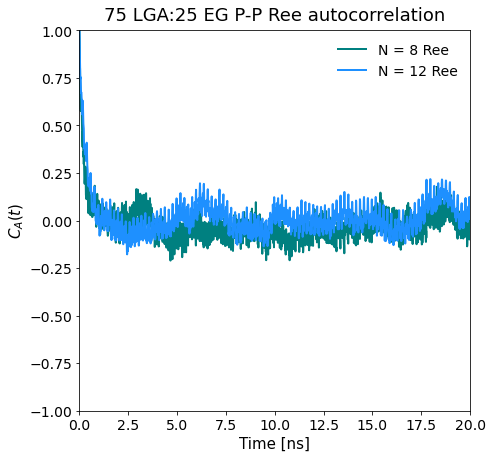

In [72]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Ree autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Ree[1]/100, ACn8wat25LGA75EG_Ree[0],linewidth=2, color='teal')
plt.plot(ACn12wat25LGA75EG_Ree[1]/100, ACn12wat25LGA75EG_Ree[0],linewidth=2, color='dodgerblue')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Ree','N = 12 Ree'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

### Hydrodynamic Radius vs time

In [73]:
n12wat25LGA75EG_rh = hydro_rad_poly(n12wat_25LGA75EG, n12_25LGA_75EG_wat, n12_mon, start, end)

(0.0, 2.0)

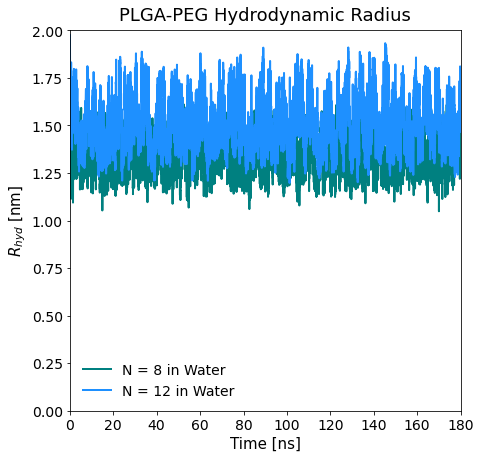

In [74]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA-PEG Hydrodynamic Radius', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{hyd}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n8wat25LGA75EG_rh/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n12wat25LGA75EG_rh/10,linewidth=2, color='dodgerblue')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,2)

#### Rh autocorrelation

In [75]:
ACn12wat25LGA75EG_Rh, eqvarRh_n12wat25LGA75EG = obs_autocorr_RA(n12wat25LGA75EG_rh,t_corr, window_shift,start,end)

No. of Samples: 801


In [76]:
ACn12wat25LGA75EG_Rh

array([[1.00000000e+00, 9.72077978e-01, 8.92514027e-01, ...,
        2.86425173e-01, 1.69442098e-01, 1.62443813e-01],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        1.99700000e+03, 1.99800000e+03, 1.99900000e+03]])

In [77]:
eqvarRh_n12wat25LGA75EG

1.8873742673591778

(0.0, 20.0)

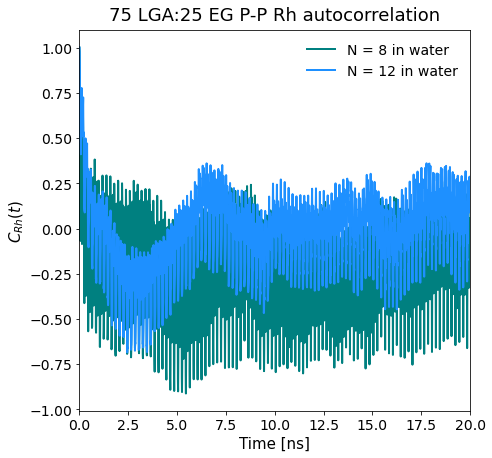

In [78]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Rh autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{Rh}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Rh[1]/100, ACn8wat25LGA75EG_Rh[0],linewidth=2, color='teal')
plt.plot(ACn12wat25LGA75EG_Rh[1]/100, ACn12wat25LGA75EG_Rh[0],linewidth=2, color='dodgerblue')
#plt.plot(A2n12plgapegwat_Ree[1]/100, ACn12plgapegwat_Ree[0],linewidth=2, color='r')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water', 'N = 12 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,20)
#plt.ylim(-0.2,1)

### Radius of Gyration vs. time N = 12 25LGA:75EG in water

In [79]:
n1225LGA75EG_rgens_wat, cor_n1225LGA75EG_wat, n1225LGA75EG_cos_wat, rgwat_n1225LGA75EG = get_rg_pers_poly(n12wat_25LGA75EG, n12_25LGA_75EG_wat,
                                                                                                  start,end)

In [80]:
n1225LGA75EG_rgens_wat[0].shape

(18001,)

In [81]:
cor_n1225LGA75EG_wat[3]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [82]:
n1225LGA75EG_cos_wat

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.94374661, 0.95681891, 0.96404585, ..., 0.88015563, 0.87977519,
        0.87286271],
       [0.95546594, 0.95008558, 0.9526648 , ..., 0.71886172, 0.76071604,
        0.73521263],
       ...,
       [0.80422915, 0.87056738, 0.93902898, ..., 0.23599635, 0.35195066,
        0.44380804],
       [0.89324538, 0.88645814, 0.99355431, ..., 0.43830292, 0.37654987,
        0.54286745],
       [0.94959817, 0.81882136, 0.99595249, ..., 0.24397032, 0.43692726,
        0.59156911]])

In [83]:
rgwat_n1225LGA75EG

6.957985728627369

In [84]:
n1225LGA75EG_rgens_wat.shape

(2, 18001)

(0.2, 2.0)

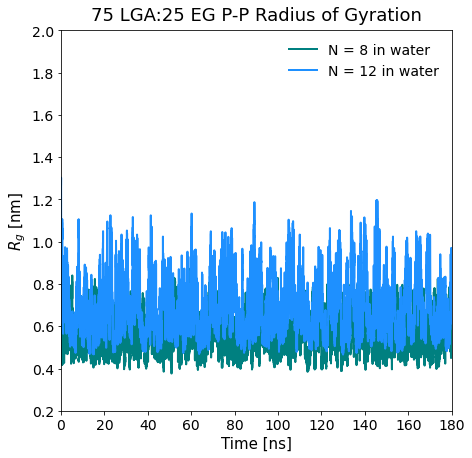

In [85]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n825LGA75EG_rgens_wat[0]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n1225LGA75EG_rgens_wat[0]/10,linewidth=2, color='dodgerblue')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water','N = 12 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

#### Rg Autocorrelation

In [86]:
ACn12wat25LGA75EG_Rg, eqvarRg_n12wat25LGA75EG = obs_autocorr_RA(n1225LGA75EG_rgens_wat[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [87]:
ACn12wat25LGA75EG_Rg

array([[1.00000000e+00, 9.13392651e-01, 8.38323474e-01, ...,
        1.64979343e-01, 9.32167473e-02, 9.90774044e-02],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        1.99700000e+03, 1.99800000e+03, 1.99900000e+03]])

In [88]:
eqvarRg_n12wat25LGA75EG

1.8543931209343683

(-1.0, 1.0)

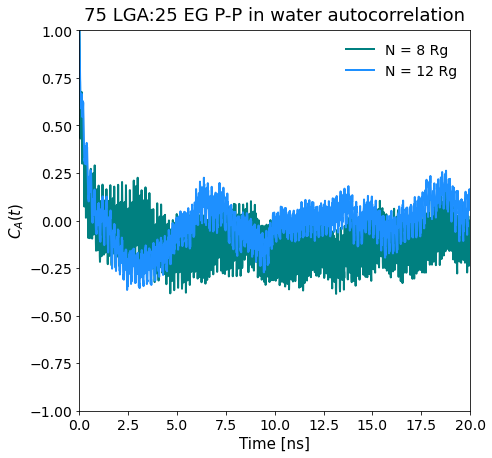

In [89]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P in water autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Rg[1]/100, ACn8wat25LGA75EG_Rg[0],linewidth=2, color='teal')
plt.plot(ACn12wat25LGA75EG_Rg[1]/100, ACn12wat25LGA75EG_Rg[0],linewidth=2, color='dodgerblue')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Rg','N = 12 Rg'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

#### Get average COM distance, Arc length values

In [90]:
cb_n12plga = np.zeros(shape=(18001))
cb_n12pplinker = np.zeros(shape=(18001))
cb_n12peg = np.zeros(shape=(18001))
count = 0
for ts in n12_25LGA_75EG_wat.trajectory[0:18001]:
    # 1st two PLGA residues
    n12m1_plga = n12_25LGA_75EG_wat.select_atoms("resid 1")
    n12m2_plga = n12_25LGA_75EG_wat.select_atoms("resid 2")
    # PLGA-PEG linker
    n12pl_link = n12_25LGA_75EG_wat.select_atoms("resid 9")
    n12peg_link = n12_25LGA_75EG_wat.select_atoms("resid 10")
    # last two PEG residues 
    n12l1_peg = n12_25LGA_75EG_wat.select_atoms("resid 11")
    n12l2_peg = n12_25LGA_75EG_wat.select_atoms("resid 12")
    
    cb_n12plga[count] = mda.analysis.distances.distance_array(n12m1_plga.center_of_mass(), n12m2_plga.center_of_mass(), 
                                                   box=n12_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    cb_n12pplinker[count] = mda.analysis.distances.distance_array(n12pl_link.center_of_mass(), n12peg_link.center_of_mass(), 
                                                   box=n12_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    cb_n12peg[count] = mda.analysis.distances.distance_array(n12l1_peg.center_of_mass(), n12l2_peg.center_of_mass(), 
                                                   box=n12_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    count += 1
    

    

In [91]:
COM_n12pp = np.zeros(shape=(3,2))
COM_n12pp[0,0] = np.mean(cb_n12plga)
COM_n12pp[1,0] = np.mean(cb_n12pplinker)
COM_n12pp[2,0] = np.mean(cb_n12peg)
COM_n12pp[0,1] = np.std(cb_n12plga)
COM_n12pp[1,1] = np.std(cb_n12pplinker)
COM_n12pp[2,1] = np.std(cb_n12peg)
COM_n12pp

array([[5.31572136, 0.73078794],
       [3.25822314, 0.1431306 ],
       [3.24268768, 0.15170013]])

#### Correlation values at each arc length from the whole 360 ns trajectory, N = 12 25LGA:75EG/water

In [92]:
# x values
blen_n12pp = np.zeros(shape=n12_mon-1)
for i in range(n12_mon-1):
    if i < int(n12_mon-9):
        # PLGA contour length values
        if i == 0:
            blen_n12pp[i] = 0
        elif i != 0:
            blen_n12pp[i] = np.sum(blen_n12pp[i-1])+ COM_n12pp[0,0]    
    elif i == int(n12_mon-9):
        #PLGA-PEG linker length
        blen_n12pp[i] = np.sum(blen_n12pp[i-1]) + COM_n12pp[1,0]
    elif i > int(n12_mon-9):
    #    # PEG contour length values
        blen_n12pp[i] = np.sum(blen_n12pp[i-1]) + COM_n12pp[2,0]
        
blen_n12pp

array([ 0.        ,  5.31572136, 10.63144272, 13.88966586, 17.13235354,
       20.37504121, 23.61772889, 26.86041657, 30.10310425, 33.34579193,
       36.58847961])

In [93]:
# Error prop. into natural log std deviation
mk_n12ppwat = cor_n1225LGA75EG_wat[1]/cor_n1225LGA75EG_wat[0]
mk_n12ppwat

array([0.        , 0.00503964, 0.01809138, 0.03934095, 0.06756956,
       0.09296629, 0.12087127, 0.15760146, 0.19830898, 0.23742897,
       0.45694623])

<ErrorbarContainer object of 3 artists>

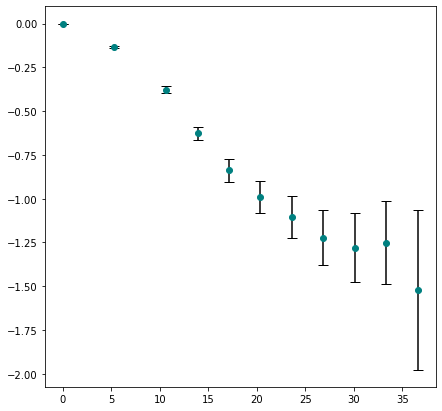

In [94]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_n12pp, np.log(cor_n1225LGA75EG_wat[0]), yerr=mk_n12ppwat, color='teal', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [95]:
# All the points give the best fits for N = 6 peg in water
n12_blks25LGA75EG_wat , n1225LGA75EG_lpwat = bavg_pers_cnt(5, n12wat_25LGA75EG, n12_25LGA_75EG_wat, blen_n12pp, 3, start, end)

0
3600
[1.         0.87475569 0.68624661 0.53120326 0.42295471 0.35967884
 0.33603397 0.31507297 0.2960062  0.25583451 0.19561371]
Lp [Angstroms]: 28.23619688973533
Error in Lp from fit [Angstroms], 95% CL : 59.90887034979317
R2 score: 0.972873453112732
3600
7200
[1.         0.86648696 0.66620186 0.50861783 0.40792008 0.34039491
 0.28828428 0.2414012  0.20708545 0.18040386 0.07439395]
Lp [Angstroms]: 26.17533902241739
Error in Lp from fit [Angstroms], 95% CL : 56.51752199051782
R2 score: 0.9719336137532626
7200
10800
[1.         0.87376955 0.68331726 0.53520365 0.44285764 0.39215002
 0.3573319  0.32096549 0.29718361 0.30754836 0.21141026]
Lp [Angstroms]: 27.91899674866342
Error in Lp from fit [Angstroms], 95% CL : 59.657878782050894
R2 score: 0.9724962300304429
10800
14400
[1.         0.87842148 0.69367903 0.54363549 0.44551822 0.38867286
 0.35045574 0.3169432  0.31201313 0.3733624  0.32379127]
Lp [Angstroms]: 29.06783663193566
Error in Lp from fit [Angstroms], 95% CL : 62.085581722802

In [96]:
n12_blks25LGA75EG_wat

{'Avg Hydrodynamic radius': array([15.018933145914842, 14.790435265776132, 15.087567353825012,
        14.859705082950004, 14.969464991295352], dtype=object),
 'Avg Radius of gyration': array([7.03342453, 6.76052756, 7.08449825, 6.92573352, 6.98082809]),
 'Avg Sq. radius of gyration': array([49.46906058, 45.70473289, 50.19011539, 47.96578472, 48.73196082]),
 'Avg end to end distance': array([16.039084  , 14.62573313, 16.43654095, 15.66038752, 15.98626971]),
 'Avg Sq. end to end distance': array([257.25221572, 213.91206952, 270.1598785 , 245.24773733,
        255.56081934]),
 'Avg persistence length': array([28.23619689, 26.17533902, 27.91899675, 29.06783663, 29.66723662])}

In [97]:
n1225LGA75EG_lpwat

array([[ 2.82361969e+01,  2.61753390e+01,  2.79189967e+01,
         2.90678366e+01,  2.96672366e+01],
       [ 5.99088703e+01,  5.65175220e+01,  5.96578788e+01,
         6.20855817e+01,  6.01689701e+01],
       [-3.54155343e-02, -3.82038987e-02, -3.58179060e-02,
        -3.44022850e-02, -3.37072176e-02],
       [ 1.97642423e-03,  2.38187890e-03,  2.05049680e-03,
         1.88996334e-03,  1.63591030e-03]])

In [98]:
n1225LGA75EG_lpwat[2]

array([-0.03541553, -0.0382039 , -0.03581791, -0.03440228, -0.03370722])

In [99]:
np.mean(n1225LGA75EG_lpwat[3])

0.001986934713244959

#### Block averaged Radius of gyration and persistence length, N = 12 25LGA:75EG/water

In [100]:
np.mean(n12_blks25LGA75EG_wat["Avg Radius of gyration"])

6.957002387519819

In [101]:
np.std(n12_blks25LGA75EG_wat["Avg Radius of gyration"])

0.11157356439881388

In [102]:
rg25LGA75EG_olig_wat[r"$R_{g}$ [Angstrom] N = 12 25LGA:75EG water"] = n12_blks25LGA75EG_wat["Avg Radius of gyration"]
rg25LGA75EG_olig_wat

,$R_{g}$ [Angstrom] N = 8 25LGA:75EG water,$R_{g}$ [Angstrom] N = 12 25LGA:75EG water
0,5.640842,7.033425
1,5.883404,6.760528
2,5.671338,7.084498
3,5.794893,6.925734
4,5.609840,6.980828


In [103]:
pers_25LGA75EG_wat[r"$L_{p}$ [Angstrom] N = 12 25LGA:75EG water"] = n12_blks25LGA75EG_wat["Avg persistence length"]
pers_25LGA75EG_wat

,$L_{p}$ [Angstrom] N = 8 25LGA:75EG water,$L_{p}$ [Angstrom] N = 12 25LGA:75EG water
0,26.173662,28.236197
1,27.191520,26.175339
2,26.357982,27.918997
3,26.336082,29.067837
4,26.082105,29.667237


### N = 16 25LGA:75EG in water

In [104]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n16_25LGA_75EG_wat = mda.Universe("n1625LGA_75EG/n1625LGA75EG_WAT.pdb", "n1625LGA_75EG/NoWat_n1625LGA_75EG.xtc")

In [105]:
n16_25LGA_75EG_wat.trajectory

<XTCReader n1625LGA_75EG/NoWat_n1625LGA_75EG.xtc with 18001 frames of 147 atoms>

In [106]:
len(n16_25LGA_75EG_wat.trajectory)

18001

In [107]:
#Select the polymer heavy atoms 
n16wat_25LGA75EG = n16_25LGA_75EG_wat.select_atoms("resname sPLG PLG bPLG bPEG PEG sPEG and not type H")

In [108]:
np.unique(n16wat_25LGA75EG.resids)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [109]:
# Get cosine theta values at frame 0 
crv_n16wat_25LGA75EG = pers_length(n16wat_25LGA75EG,16)
crv_n16wat_25LGA75EG

array([[ 1.        ,  0.93699699,  0.94845319,  0.9129976 ,  0.91527222,
         0.89245461,  0.8948672 ,  0.88978402,  0.88023308,  0.85262966,
         0.8272211 ,  0.79909033,  0.88494845,  0.91677363,  0.89553732],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        , 11.        , 12.        , 13.        , 14.        ],
       [ 0.        , 20.4467943 , 18.47659532, 24.07705853, 23.75558427,
        26.81666861, 26.50862327, 27.15388023, 28.32950743, 31.50115208,
        34.18567278, 36.95667687, 27.7548221 , 23.54112458, 26.42246928]])

### Mean squared end to end distance 

In [110]:
n16_mon = 16
start = 0
end = 18001
trj_len = np.arange(18001)

In [111]:
eVec_n16wat25LGA75EG, e2edis_n16wat25LGA75EG = mean_sq_e2e(n16wat_25LGA75EG, n16_25LGA_75EG_wat, n16_mon, start, end)

(0.0, 5.0)

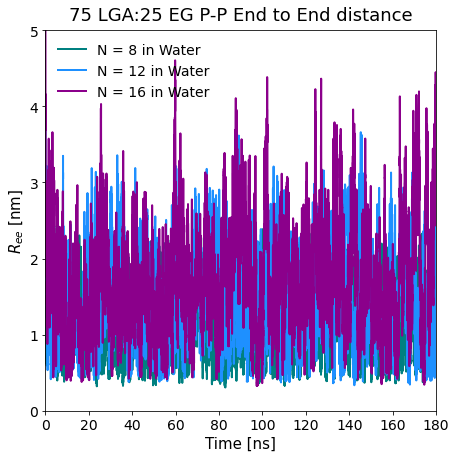

In [112]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P End to End distance', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{ee}$ [nm]', fontsize=15)
plt.plot(trj_len/100, e2edis_n8wat25LGA75EG[1]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, e2edis_n12wat25LGA75EG[1]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, e2edis_n16wat25LGA75EG[1]/10,linewidth=2, color='darkmagenta')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,5)

#### Ree Autocorrelation function

In [113]:
e2edis_n16wat25LGA75EG[1]

array([51.88069112, 46.82702644, 38.66630187, ..., 36.96799409,
       37.72903135, 38.07203099])

In [ ]:
t_corr = 2000
window_shift = 20

In [114]:
ACn16wat25LGA75EG_Ree, eqvar_n16wat25LGA75EG = obs_autocorr_RA(e2edis_n16wat25LGA75EG[1],t_corr, window_shift,start,end)

No. of Samples: 801


In [115]:
ACn16wat25LGA75EG_Ree

array([[1.00000000e+00, 9.63466950e-01, 9.24911542e-01, ...,
        1.82323494e-01, 1.37675291e-01, 1.63788399e-01],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        1.99700000e+03, 1.99800000e+03, 1.99900000e+03]])

In [116]:
eqvar_n16wat25LGA75EG

47.264648165543974

In [117]:
ACn16wat25LGA75EG_sqRee, evsqRee_n16wat25LGA75EG = obs_autocorr_RA(e2edis_n16wat25LGA75EG[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [118]:
np.sqrt(evsqRee_n16wat25LGA75EG)

274.2716226495777

(-1.0, 1.0)

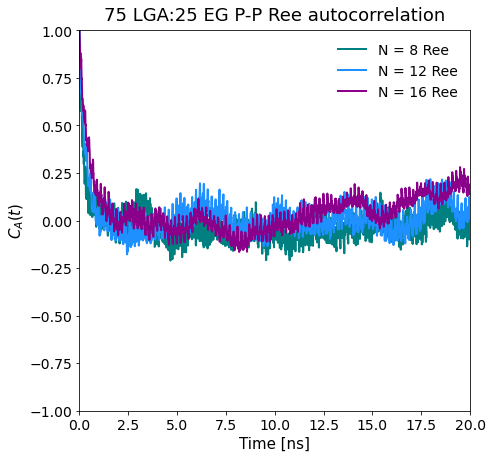

In [119]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Ree autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Ree[1]/100, ACn8wat25LGA75EG_Ree[0],linewidth=2, color='teal')
plt.plot(ACn16wat25LGA75EG_Ree[1]/100, ACn12wat25LGA75EG_Ree[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat25LGA75EG_Ree[1]/100, ACn16wat25LGA75EG_Ree[0],linewidth=2, color='darkmagenta')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Ree','N = 12 Ree','N = 16 Ree' ], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

### Hydrodynamic Radius vs time

In [120]:
n16wat25LGA75EG_rh = hydro_rad_poly(n16wat_25LGA75EG, n16_25LGA_75EG_wat, n16_mon, start, end)

(0.0, 2.0)

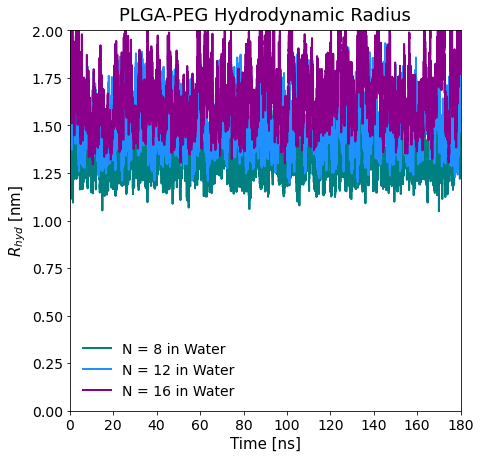

In [121]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA-PEG Hydrodynamic Radius', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{hyd}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n8wat25LGA75EG_rh/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n12wat25LGA75EG_rh/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n16wat25LGA75EG_rh/10,linewidth=2, color='darkmagenta')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water', 'N = 16 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,2)

#### Rh autocorrelation

In [122]:
ACn16wat25LGA75EG_Rh, eqvarRh_n16wat25LGA75EG = obs_autocorr_RA(n16wat25LGA75EG_rh,t_corr, window_shift,start,end)

No. of Samples: 801


In [123]:
ACn16wat25LGA75EG_Rh

array([[1.00000000e+00, 1.13711402e+00, 1.03895777e+00, ...,
        1.13564743e+00, 1.15586628e+00, 1.03086262e+00],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        1.99700000e+03, 1.99800000e+03, 1.99900000e+03]])

In [124]:
eqvarRh_n16wat25LGA75EG

2.4429106787496266

(0.0, 20.0)

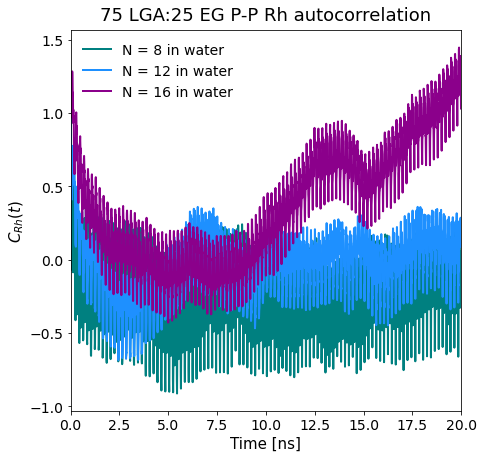

In [125]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Rh autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{Rh}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Rh[1]/100, ACn8wat25LGA75EG_Rh[0],linewidth=2, color='teal')
plt.plot(ACn12wat25LGA75EG_Rh[1]/100, ACn12wat25LGA75EG_Rh[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat25LGA75EG_Rh[1]/100, ACn16wat25LGA75EG_Rh[0],linewidth=2, color='darkmagenta')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water', 'N = 12 in water','N = 16 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,20)
#plt.ylim(-0.2,1)

### Radius of Gyration vs. time N = 16 25LGA:75EG in water

In [126]:
n1625LGA75EG_rgens_wat, cor_n1625LGA75EG_wat, n1625LGA75EG_cos_wat, rgwat_n1625LGA75EG = get_rg_pers_poly(n16wat_25LGA75EG, n16_25LGA_75EG_wat,
                                                                                                  start,end)

In [127]:
n1625LGA75EG_rgens_wat[0].shape

(18001,)

In [128]:
cor_n1625LGA75EG_wat[3]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14.])

In [129]:
n1625LGA75EG_cos_wat

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.93699699, 0.93708459, 0.92499866, ..., 0.9096106 , 0.91515852,
        0.90914622],
       [0.94845319, 0.91069851, 0.8826329 , ..., 0.83256203, 0.85515163,
        0.80560043],
       ...,
       [0.88494845, 0.81216628, 0.77336434, ..., 0.57679564, 0.53807639,
        0.62597068],
       [0.91677363, 0.74890354, 0.77781789, ..., 0.4085031 , 0.41318975,
        0.56847629],
       [0.89553732, 0.72608091, 0.79782934, ..., 0.02448867, 0.15590653,
        0.18990829]])

In [130]:
rgwat_n1625LGA75EG

8.07618524286814

In [131]:
n1625LGA75EG_rgens_wat.shape

(2, 18001)

(0.2, 2.0)

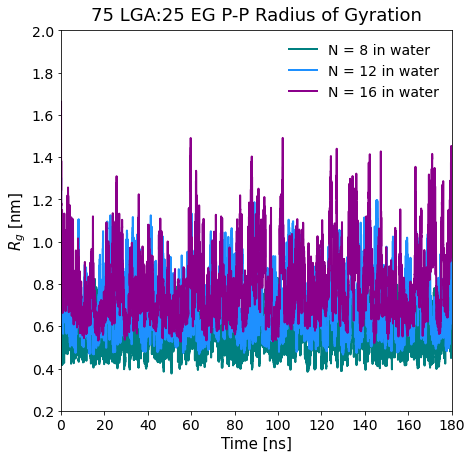

In [132]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n825LGA75EG_rgens_wat[0]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n1225LGA75EG_rgens_wat[0]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n1625LGA75EG_rgens_wat[0]/10,linewidth=2, color='darkmagenta')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water','N = 12 in water','N = 16 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

#### Rg Autocorrelation

In [133]:
ACn16wat25LGA75EG_Rg, eqvarRg_n16wat25LGA75EG = obs_autocorr_RA(n1625LGA75EG_rgens_wat[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [134]:
ACn16wat25LGA75EG_Rg

array([[1.00000000e+00, 1.00654225e+00, 9.62087543e-01, ...,
        4.82182498e-01, 4.39693854e-01, 4.30308962e-01],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        1.99700000e+03, 1.99800000e+03, 1.99900000e+03]])

In [135]:
eqvarRg_n16wat25LGA75EG

2.499188584997107

(-1.0, 1.0)

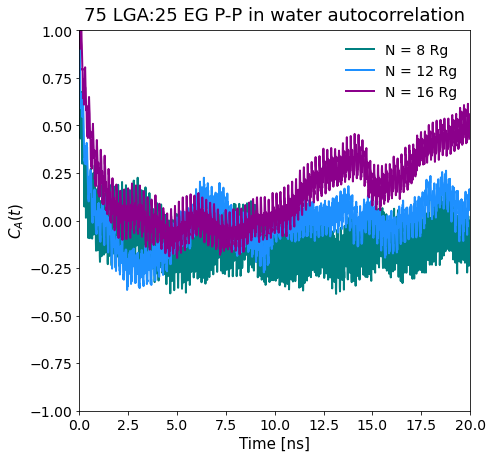

In [136]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P in water autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Rg[1]/100, ACn8wat25LGA75EG_Rg[0],linewidth=2, color='teal')
plt.plot(ACn12wat25LGA75EG_Rg[1]/100, ACn12wat25LGA75EG_Rg[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat25LGA75EG_Rg[1]/100, ACn16wat25LGA75EG_Rg[0],linewidth=2, color='darkmagenta')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Rg','N = 12 Rg','N = 16 Rg'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

#### Get average COM distance, Arc length values

In [137]:
cb_n16plga = np.zeros(shape=(18001))
cb_n16pplinker = np.zeros(shape=(18001))
cb_n16peg = np.zeros(shape=(18001))
count = 0
for ts in n16_25LGA_75EG_wat.trajectory[0:18001]:
    # 1st two PLGA residues
    n16m1_plga = n16_25LGA_75EG_wat.select_atoms("resid 1")
    n16m2_plga = n16_25LGA_75EG_wat.select_atoms("resid 2")
    # PLGA-PEG linker
    n16pl_link = n16_25LGA_75EG_wat.select_atoms("resid 12")
    n16peg_link = n16_25LGA_75EG_wat.select_atoms("resid 13")
    # last two PEG residues 
    n16l1_peg = n16_25LGA_75EG_wat.select_atoms("resid 15")
    n16l2_peg = n16_25LGA_75EG_wat.select_atoms("resid 16")
    
    cb_n16plga[count] = mda.analysis.distances.distance_array(n16m1_plga.center_of_mass(), n16m2_plga.center_of_mass(), 
                                                   box=n16_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    cb_n16pplinker[count] = mda.analysis.distances.distance_array(n16pl_link.center_of_mass(), n16peg_link.center_of_mass(), 
                                                   box=n16_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    cb_n16peg[count] = mda.analysis.distances.distance_array(n16l1_peg.center_of_mass(), n16l2_peg.center_of_mass(), 
                                                   box=n16_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    count += 1
    

    

In [138]:
COM_n16pp = np.zeros(shape=(3,2))
COM_n16pp[0,0] = np.mean(cb_n16plga)
COM_n16pp[1,0] = np.mean(cb_n16pplinker)
COM_n16pp[2,0] = np.mean(cb_n16peg)
COM_n16pp[0,1] = np.std(cb_n16plga)
COM_n16pp[1,1] = np.std(cb_n16pplinker)
COM_n16pp[2,1] = np.std(cb_n16peg)
COM_n16pp

array([[5.41144008, 0.74599387],
       [3.25378008, 0.15078943],
       [3.24185124, 0.15286029]])

#### Correlation values at each arc length from the whole 360 ns trajectory, N = 16 25LGA:75EG/water

In [139]:
# x values
blen_n16pp = np.zeros(shape=n16_mon-1)
for i in range(n16_mon-1):
    if i < int(n16_mon-12):
        # PLGA contour length values
        if i == 0:
            blen_n16pp[i] = 0
        elif i != 0:
            blen_n16pp[i] = np.sum(blen_n16pp[i-1])+ COM_n16pp[0,0]    
    elif i == int(n16_mon-12):
        #PLGA-PEG linker length
        blen_n16pp[i] = np.sum(blen_n16pp[i-1]) + COM_n16pp[1,0]
    elif i > int(n16_mon-12):
    #    # PEG contour length values
        blen_n16pp[i] = np.sum(blen_n16pp[i-1]) + COM_n16pp[2,0]
        
blen_n16pp

array([ 0.        ,  5.41144008, 10.82288016, 16.23432025, 19.48810033,
       22.72995157, 25.97180282, 29.21365406, 32.45550531, 35.69735655,
       38.9392078 , 42.18105904, 45.42291028, 48.66476153, 51.90661277])

In [140]:
# Error prop. into natural log std deviation
mk_n16ppwat = cor_n1625LGA75EG_wat[1]/cor_n1625LGA75EG_wat[0]
mk_n16ppwat

array([0.        , 0.00379823, 0.01443109, 0.030923  , 0.05094427,
       0.07018754, 0.08911413, 0.11422219, 0.13907641, 0.16037495,
       0.17346088, 0.18105418, 0.20934071, 0.34784494, 0.57922996])

<ErrorbarContainer object of 3 artists>

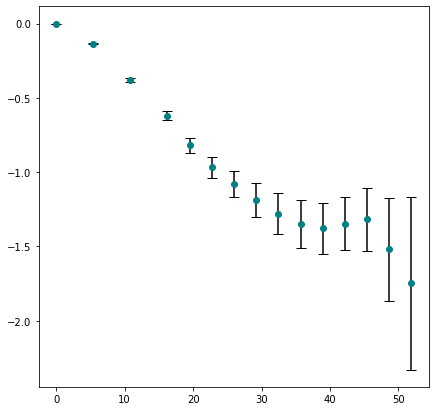

In [141]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_n16pp, np.log(cor_n1625LGA75EG_wat[0]), yerr=mk_n16ppwat, color='teal', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [142]:
# All the points give the best fits for N = 6 peg in water
n16_blks25LGA75EG_wat , n1625LGA75EG_lpwat = bavg_pers_cnt(5, n16wat_25LGA75EG, n16_25LGA_75EG_wat, blen_n16pp, 3, start, end)

0
3600
[1.         0.86918508 0.66659683 0.50622016 0.40380742 0.34600709
 0.31426647 0.2863346  0.26511807 0.25887879 0.26921841 0.28627464
 0.26029039 0.16628432 0.08674713]
Lp [Angstroms]: 26.685611968069253
Error in Lp from fit [Angstroms], 95% CL : 60.41879897397134
R2 score: 0.969226051435707
3600
7200
[1.         0.87102267 0.67399924 0.52389873 0.42119869 0.35715583
 0.31315361 0.27638474 0.24694003 0.22052111 0.20799762 0.2155595
 0.23824039 0.20627286 0.19501729]
Lp [Angstroms]: 27.432595078624956
Error in Lp from fit [Angstroms], 95% CL : 60.369949065296126
R2 score: 0.9708767241155151
7200
10800
[1.         0.87322696 0.6785566  0.53429821 0.4421661  0.38849547
 0.35141474 0.319264   0.29426566 0.27677201 0.26474209 0.26380513
 0.26162019 0.18179798 0.14193754]
Lp [Angstroms]: 27.90931463877871
Error in Lp from fit [Angstroms], 95% CL : 61.59732378930003
R2 score: 0.9707123712437351
10800
14400
[1.         0.8758643  0.69487749 0.5602741  0.47095759 0.41554378
 0.37750211 0

In [143]:
n16_blks25LGA75EG_wat

{'Avg Hydrodynamic radius': array([15.969709785544264, 16.094741319855217, 16.44630950832145,
        16.79130799167273, 16.43754346958001], dtype=object),
 'Avg Radius of gyration': array([7.78036882, 7.62848582, 8.21175397, 8.43030689, 8.29827917]),
 'Avg Sq. radius of gyration': array([60.53413898, 58.1937959 , 67.43290329, 71.07007418, 68.8614372 ]),
 'Avg end to end distance': array([17.1387983 , 17.02717314, 19.47147685, 19.88283881, 19.61710593]),
 'Avg Sq. end to end distance': array([293.7384072 , 289.92462519, 379.13841066, 395.32727904,
        384.83084516]),
 'Avg persistence length': array([26.68561197, 27.43259508, 27.90931464, 29.73157577, 30.55052552])}

In [144]:
n1625LGA75EG_lpwat

array([[ 2.66856120e+01,  2.74325951e+01,  2.79093146e+01,
         2.97315758e+01,  3.05505255e+01],
       [ 6.04187990e+01,  6.03699491e+01,  6.15973238e+01,
         5.92765387e+01,  5.99350759e+01],
       [-3.74733771e-02, -3.64529858e-02, -3.58303317e-02,
        -3.36342751e-02, -3.27326612e-02],
       [ 2.61131651e-03,  2.33452244e-03,  2.26856385e-03,
         1.63124040e-03,  1.49593039e-03]])

In [145]:
n1625LGA75EG_lpwat[2]

array([-0.03747338, -0.03645299, -0.03583033, -0.03363428, -0.03273266])

In [146]:
np.mean(n1625LGA75EG_lpwat[3])

0.002068314717323049

#### Block averaged Radius of gyration and persistence length, N = 16 25LGA:75EG/water

In [147]:
np.mean(n16_blks25LGA75EG_wat["Avg Radius of gyration"])

8.06983893348041

In [148]:
np.std(n16_blks25LGA75EG_wat["Avg Radius of gyration"])

0.3101120708060586

In [149]:
rg25LGA75EG_olig_wat[r"$R_{g}$ [Angstrom] N = 16 25LGA:75EG water"] = n16_blks25LGA75EG_wat["Avg Radius of gyration"]
rg25LGA75EG_olig_wat

,$R_{g}$ [Angstrom] N = 8 25LGA:75EG water,$R_{g}$ [Angstrom] N = 12 25LGA:75EG water,$R_{g}$ [Angstrom] N = 16 25LGA:75EG water
0,5.640842,7.033425,7.780369
1,5.883404,6.760528,7.628486
2,5.671338,7.084498,8.211754
3,5.794893,6.925734,8.430307
4,5.609840,6.980828,8.298279


In [150]:
pers_25LGA75EG_wat[r"$L_{p}$ [Angstrom] N = 16 25LGA:75EG water"] = n16_blks25LGA75EG_wat["Avg persistence length"]
pers_25LGA75EG_wat

,$L_{p}$ [Angstrom] N = 8 25LGA:75EG water,$L_{p}$ [Angstrom] N = 12 25LGA:75EG water,$L_{p}$ [Angstrom] N = 16 25LGA:75EG water
0,26.173662,28.236197,26.685612
1,27.191520,26.175339,27.432595
2,26.357982,27.918997,27.909315
3,26.336082,29.067837,29.731576
4,26.082105,29.667237,30.550526


### N = 20 25LGA:75EG in water

In [151]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n20_25LGA_75EG_wat = mda.Universe("n2025LGA_75EG/n2025LGA75EG_WAT.pdb", "n2025LGA_75EG/NoWat_n2025LGA_75EG.xtc")

In [152]:
n20_25LGA_75EG_wat.trajectory

<XTCReader n2025LGA_75EG/NoWat_n2025LGA_75EG.xtc with 18001 frames of 183 atoms>

In [153]:
len(n20_25LGA_75EG_wat.trajectory)

18001

In [154]:
#Select the polymer heavy atoms 
n20wat_25LGA75EG = n20_25LGA_75EG_wat.select_atoms("resname sPLG PLG bPLG bPEG PEG sPEG and not type H")

In [155]:
np.unique(n20wat_25LGA75EG.resids)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [156]:
# Get cosine theta values at frame 0 
crv_n20wat_25LGA75EG = pers_length(n20wat_25LGA75EG,20)
crv_n20wat_25LGA75EG

array([[ 1.        ,  0.93877116,  0.95248476,  0.92350966,  0.93010948,
         0.90748209,  0.90988741,  0.89582032,  0.89256876,  0.87580622,
         0.86812802,  0.85520001,  0.8517941 ,  0.84208061,  0.8264044 ,
         0.90101457,  0.92414748,  0.9385181 ,  0.94228758],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        , 11.        , 12.        , 13.        , 14.        ,
        15.        , 16.        , 17.        , 18.        ],
       [ 0.        , 20.15379713, 17.73327362, 22.5553134 , 21.54811258,
        24.84031882, 24.51020232, 26.38600714, 26.80216785, 28.85946469,
        29.75817278, 31.21816172, 31.59265438, 32.63951661, 34.26886487,
        25.70825046, 22.45984818, 20.19583791, 19.56065585]])

### Mean squared end to end distance 

In [157]:
n20_mon = 20
start = 0
end = 18001
trj_len = np.arange(18001)

In [158]:
eVec_n20wat25LGA75EG, e2edis_n20wat25LGA75EG = mean_sq_e2e(n20wat_25LGA75EG, n20_25LGA_75EG_wat, n20_mon, start, end)

(0.0, 5.0)

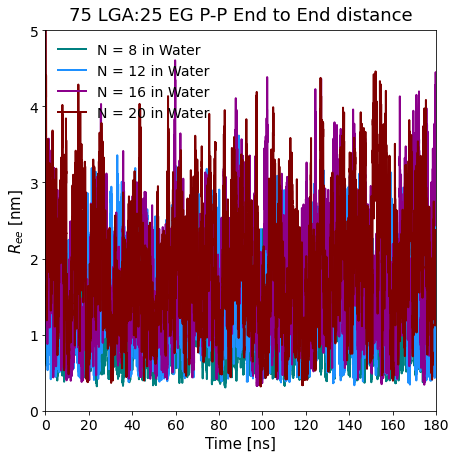

In [159]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P End to End distance', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{ee}$ [nm]', fontsize=15)
plt.plot(trj_len/100, e2edis_n8wat25LGA75EG[1]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, e2edis_n12wat25LGA75EG[1]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, e2edis_n16wat25LGA75EG[1]/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, e2edis_n20wat25LGA75EG[1]/10,linewidth=2, color='maroon')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water','N = 20 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,5)

#### Ree Autocorrelation function

In [160]:
e2edis_n20wat25LGA75EG[1]

array([66.67003824, 64.01562633, 63.24769617, ..., 14.51425059,
       13.40239858, 15.105567  ])

In [ ]:
t_corr = 2000
window_shift = 20

In [161]:
ACn20wat25LGA75EG_Ree, eqvar_n20wat25LGA75EG = obs_autocorr_RA(e2edis_n20wat25LGA75EG[1],t_corr, window_shift,start,end)

No. of Samples: 801


In [162]:
ACn20wat25LGA75EG_Ree

array([[ 1.00000000e+00,  9.74699350e-01,  9.88005674e-01, ...,
        -1.50103599e-02, -4.02795779e-02, -6.89651581e-03],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [163]:
eqvar_n20wat25LGA75EG

62.64421971299441

In [164]:
ACn20wat25LGA75EG_sqRee, evsqRee_n20wat25LGA75EG = obs_autocorr_RA(e2edis_n20wat25LGA75EG[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [165]:
np.sqrt(evsqRee_n20wat25LGA75EG)

350.29547748382623

(-1.0, 1.0)

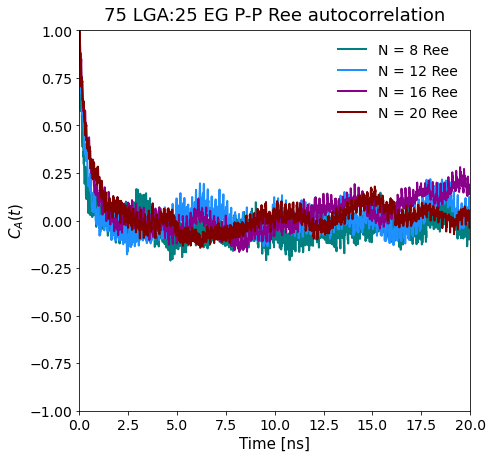

In [166]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Ree autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Ree[1]/100, ACn8wat25LGA75EG_Ree[0],linewidth=2, color='teal')
plt.plot(ACn12wat25LGA75EG_Ree[1]/100, ACn12wat25LGA75EG_Ree[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat25LGA75EG_Ree[1]/100, ACn16wat25LGA75EG_Ree[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat25LGA75EG_Ree[1]/100, ACn20wat25LGA75EG_Ree[0],linewidth=2, color='maroon')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Ree','N = 12 Ree','N = 16 Ree','N = 20 Ree'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

### Hydrodynamic Radius vs time

In [167]:
n20wat25LGA75EG_rh = hydro_rad_poly(n20wat_25LGA75EG, n20_25LGA_75EG_wat, n20_mon, start, end)

(0.0, 2.0)

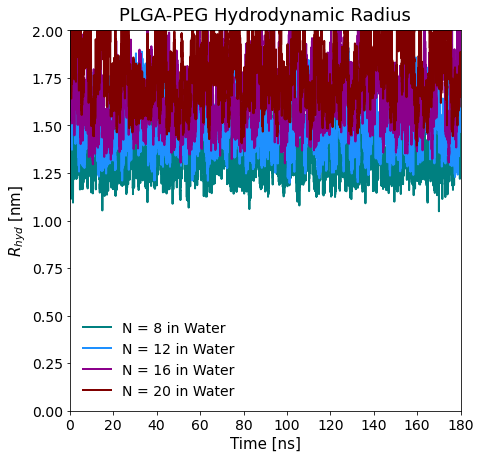

In [168]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA-PEG Hydrodynamic Radius', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{hyd}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n8wat25LGA75EG_rh/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n12wat25LGA75EG_rh/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n16wat25LGA75EG_rh/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, n20wat25LGA75EG_rh/10,linewidth=2, color='maroon')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water','N = 20 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,2)

#### Rh autocorrelation

In [169]:
ACn20wat25LGA75EG_Rh, eqvarRh_n20wat25LGA75EG = obs_autocorr_RA(n20wat25LGA75EG_rh,t_corr, window_shift,start,end)

No. of Samples: 801


In [170]:
ACn20wat25LGA75EG_Rh

array([[ 1.00000000e+00,  9.95318108e-01,  1.09104981e+00, ...,
        -6.48302282e-01, -6.43403529e-01, -6.02581314e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [171]:
eqvarRh_n20wat25LGA75EG

3.1074200026483254

(0.0, 20.0)

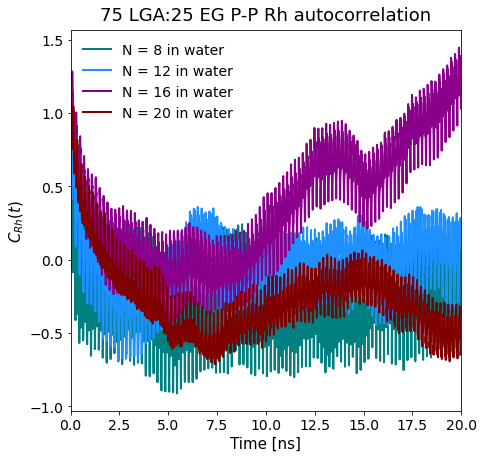

In [172]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Rh autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{Rh}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Rh[1]/100, ACn8wat25LGA75EG_Rh[0],linewidth=2, color='teal')
plt.plot(ACn12wat25LGA75EG_Rh[1]/100, ACn12wat25LGA75EG_Rh[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat25LGA75EG_Rh[1]/100, ACn16wat25LGA75EG_Rh[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat25LGA75EG_Rh[1]/100, ACn20wat25LGA75EG_Rh[0],linewidth=2, color='maroon')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water', 'N = 12 in water','N = 16 in water','N = 20 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,20)
#plt.ylim(-0.2,1)

### Radius of Gyration vs. time N = 20 25LGA:75EG in water

In [173]:
n2025LGA75EG_rgens_wat, cor_n2025LGA75EG_wat, n2025LGA75EG_cos_wat, rgwat_n2025LGA75EG = get_rg_pers_poly(n20wat_25LGA75EG, n20_25LGA_75EG_wat,
                                                                                                  start,end)

In [174]:
n2025LGA75EG_rgens_wat[0].shape

(18001,)

In [175]:
cor_n2025LGA75EG_wat[3]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18.])

In [176]:
n2025LGA75EG_cos_wat

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.93877116, 0.94593726, 0.94915424, ..., 0.88267388, 0.86519331,
        0.8860429 ],
       [0.95248476, 0.91038543, 0.9037302 , ..., 0.74311939, 0.69461148,
        0.74698977],
       ...,
       [0.92414748, 0.929223  , 0.95304445, ..., 0.58396694, 0.54483071,
        0.51382729],
       [0.9385181 , 0.96352107, 0.97067017, ..., 0.67073385, 0.57099663,
        0.70569802],
       [0.94228758, 0.97195512, 0.99255956, ..., 0.4557641 , 0.36176749,
        0.57622492]])

In [177]:
rgwat_n2025LGA75EG

8.985436751949061

In [178]:
n2025LGA75EG_rgens_wat.shape

(2, 18001)

(0.2, 2.0)

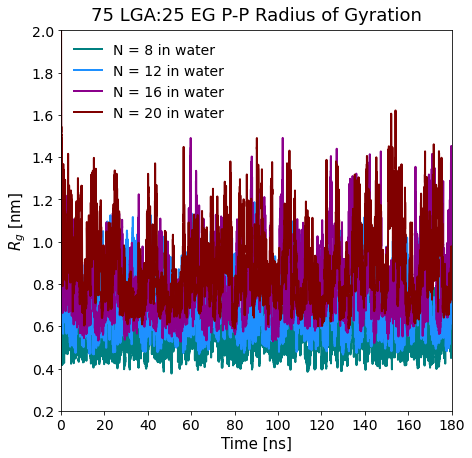

In [179]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n825LGA75EG_rgens_wat[0]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n1225LGA75EG_rgens_wat[0]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n1625LGA75EG_rgens_wat[0]/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, n2025LGA75EG_rgens_wat[0]/10,linewidth=2, color='maroon')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water','N = 12 in water','N = 16 in water','N = 20 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

#### Rg Autocorrelation

In [180]:
ACn20wat25LGA75EG_Rg, eqvarRg_n20wat25LGA75EG = obs_autocorr_RA(n2025LGA75EG_rgens_wat[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [181]:
ACn20wat25LGA75EG_Rg

array([[ 1.00000000e+00,  9.93784696e-01,  1.02472387e+00, ...,
        -3.62119775e-01, -3.56195176e-01, -3.28700336e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [182]:
eqvarRg_n20wat25LGA75EG

3.1046035358648965

(-1.0, 1.0)

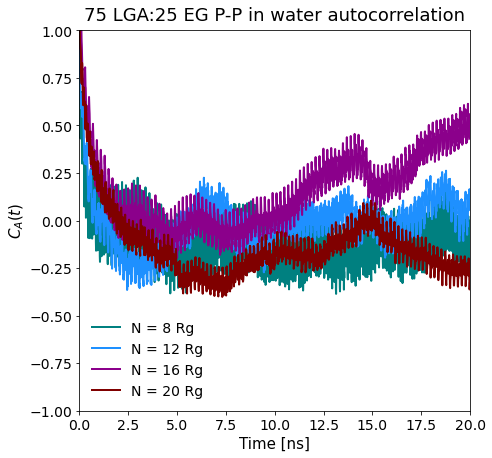

In [183]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P in water autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Rg[1]/100, ACn8wat25LGA75EG_Rg[0],linewidth=2, color='teal')
plt.plot(ACn12wat25LGA75EG_Rg[1]/100, ACn12wat25LGA75EG_Rg[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat25LGA75EG_Rg[1]/100, ACn16wat25LGA75EG_Rg[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat25LGA75EG_Rg[1]/100, ACn20wat25LGA75EG_Rg[0],linewidth=2, color='maroon')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Rg','N = 12 Rg','N = 16 Rg','N = 20 Rg'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

#### Get average COM distance, Arc length values

In [184]:
cb_n20plga = np.zeros(shape=(18001))
cb_n20pplinker = np.zeros(shape=(18001))
cb_n20peg = np.zeros(shape=(18001))
count = 0
for ts in n20_25LGA_75EG_wat.trajectory[0:18001]:
    # 1st two PLGA residues
    n20m1_plga = n20_25LGA_75EG_wat.select_atoms("resid 1")
    n20m2_plga = n20_25LGA_75EG_wat.select_atoms("resid 2")
    # PLGA-PEG linker
    n20pl_link = n20_25LGA_75EG_wat.select_atoms("resid 15")
    n20peg_link = n20_25LGA_75EG_wat.select_atoms("resid 16")
    # last two PEG residues 
    n20l1_peg = n20_25LGA_75EG_wat.select_atoms("resid 19")
    n20l2_peg = n20_25LGA_75EG_wat.select_atoms("resid 20")
    
    cb_n20plga[count] = mda.analysis.distances.distance_array(n20m1_plga.center_of_mass(), n20m2_plga.center_of_mass(), 
                                                   box=n20_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    cb_n20pplinker[count] = mda.analysis.distances.distance_array(n20pl_link.center_of_mass(), n20peg_link.center_of_mass(), 
                                                   box=n20_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    cb_n20peg[count] = mda.analysis.distances.distance_array(n20l1_peg.center_of_mass(), n20l2_peg.center_of_mass(), 
                                                   box=n20_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    count += 1
    

    

In [185]:
COM_n20pp = np.zeros(shape=(3,2))
COM_n20pp[0,0] = np.mean(cb_n20plga)
COM_n20pp[1,0] = np.mean(cb_n20pplinker)
COM_n20pp[2,0] = np.mean(cb_n20peg)
COM_n20pp[0,1] = np.std(cb_n20plga)
COM_n20pp[1,1] = np.std(cb_n20pplinker)
COM_n20pp[2,1] = np.std(cb_n20peg)
COM_n20pp

array([[5.39955937, 0.72114935],
       [3.24749787, 0.15495253],
       [3.24305952, 0.15174518]])

#### Correlation values at each arc length from the whole 360 ns trajectory, N = 20 25LGA:75EG/water

In [186]:
# x values
blen_n20pp = np.zeros(shape=n20_mon-1)
for i in range(n20_mon-1):
    if i < int(n20_mon-15):
        # PLGA contour length values
        if i == 0:
            blen_n20pp[i] = 0
        elif i != 0:
            blen_n20pp[i] = np.sum(blen_n20pp[i-1])+ COM_n20pp[0,0]    
    elif i == int(n20_mon-15):
        #PLGA-PEG linker length
        blen_n20pp[i] = np.sum(blen_n20pp[i-1]) + COM_n20pp[1,0]
    elif i > int(n20_mon-15):
    #    # PEG contour length values
        blen_n20pp[i] = np.sum(blen_n20pp[i-1]) + COM_n20pp[2,0]
        
blen_n20pp

array([ 0.        ,  5.39955937, 10.79911874, 16.19867811, 21.59823748,
       24.84573536, 28.08879488, 31.3318544 , 34.57491392, 37.81797344,
       41.06103296, 44.30409248, 47.547152  , 50.79021152, 54.03327105,
       57.27633057, 60.51939009, 63.76244961, 67.00550913])

In [187]:
# Error prop. into natural log std deviation
mk_n20ppwat = cor_n2025LGA75EG_wat[1]/cor_n2025LGA75EG_wat[0]
mk_n20ppwat

array([0.        , 0.00350075, 0.01118798, 0.02411421, 0.03858345,
       0.05113233, 0.06424294, 0.07971549, 0.10011391, 0.12195876,
       0.1480833 , 0.16820418, 0.18589951, 0.19589988, 0.21216039,
       0.23985235, 0.3708815 , 0.55559676, 0.58013705])

<ErrorbarContainer object of 3 artists>

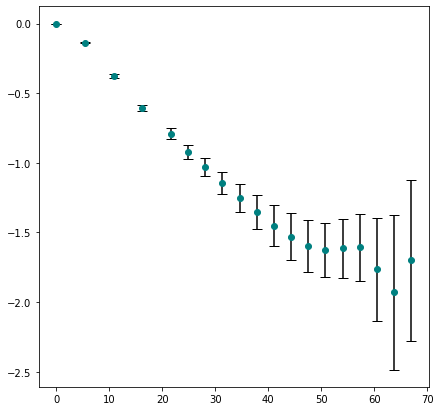

In [188]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_n20pp, np.log(cor_n2025LGA75EG_wat[0]), yerr=mk_n20ppwat, color='teal', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [189]:
# All the points give the best fits for N = 6 peg in water
n20_blks25LGA75EG_wat , n2025LGA75EG_lpwat = bavg_pers_cnt(5, n20wat_25LGA75EG, n20_25LGA_75EG_wat, blen_n20pp, 3, start, end)

0
3600
[1.         0.87507091 0.68448608 0.54038277 0.44594046 0.39530269
 0.35832723 0.32189149 0.28952053 0.25456309 0.22023034 0.19484689
 0.18347102 0.1877053  0.21182474 0.24261791 0.22620235 0.17314316
 0.22213631]
Lp [Angstroms]: 28.487179871053637
Error in Lp from fit [Angstroms], 95% CL : 61.84513111390207
R2 score: 0.9716349506019297
3600
7200
[1.         0.86875051 0.6829492  0.54083673 0.43532537 0.37127115
 0.32918756 0.28470144 0.23470856 0.18331491 0.13972068 0.1183561
 0.11473018 0.12491811 0.14849307 0.166698   0.12211006 0.14311643
 0.19164828]
Lp [Angstroms]: 28.319258285936673
Error in Lp from fit [Angstroms], 95% CL : 54.44444384479236
R2 score: 0.9776189077476364
7200
10800
[1.         0.87523541 0.69570928 0.55058247 0.4649007  0.41063436
 0.36874914 0.33064349 0.29916334 0.28172512 0.26952144 0.25123261
 0.22660425 0.20995685 0.20455169 0.20093287 0.17947246 0.14315493
 0.14834069]
Lp [Angstroms]: 29.76411815270729
Error in Lp from fit [Angstroms], 95% CL : 57.9

In [190]:
n20_blks25LGA75EG_wat

{'Avg Hydrodynamic radius': array([17.88941368505527, 17.333797273601824, 17.890033243818046,
        17.524431489003412, 18.09854814869855], dtype=object),
 'Avg Radius of gyration': array([9.13829503, 8.39308735, 9.16066367, 8.6855151 , 9.50701612]),
 'Avg Sq. radius of gyration': array([83.50843603, 70.44391518, 83.91775881, 75.43817259, 90.38335559]),
 'Avg end to end distance': array([20.98599308, 18.95961851, 20.05117964, 19.52250475, 23.26900546]),
 'Avg Sq. end to end distance': array([440.41190571, 359.46713404, 402.04980508, 381.12819156,
        541.4466149 ]),
 'Avg persistence length': array([28.48717987, 28.31925829, 29.76411815, 28.24528027, 28.71261277])}

In [191]:
n2025LGA75EG_lpwat

array([[ 2.84871799e+01,  2.83192583e+01,  2.97641182e+01,
         2.82452803e+01,  2.87126128e+01],
       [ 6.18451311e+01,  5.44444438e+01,  5.79526101e+01,
         5.70437178e+01,  5.62256684e+01],
       [-3.51035099e-02, -3.53116593e-02, -3.35975014e-02,
        -3.54041451e-02, -3.48278998e-02],
       [ 2.09762639e-03,  1.66454129e-03,  1.54557065e-03,
         1.84649030e-03,  1.67993833e-03]])

In [192]:
n2025LGA75EG_lpwat[2]

array([-0.03510351, -0.03531166, -0.0335975 , -0.03540415, -0.0348279 ])

In [193]:
np.mean(n2025LGA75EG_lpwat[3])

0.0017668333919047129

#### Block averaged Radius of gyration and persistence length, N = 20 25LGA:75EG/water

In [194]:
np.mean(n20_blks25LGA75EG_wat["Avg Radius of gyration"])

8.97691545334151

In [195]:
np.std(n20_blks25LGA75EG_wat["Avg Radius of gyration"])

0.39155661634711114

In [196]:
rg25LGA75EG_olig_wat[r"$R_{g}$ [Angstrom] N = 20 25LGA:75EG water"] = n20_blks25LGA75EG_wat["Avg Radius of gyration"]
rg25LGA75EG_olig_wat

,$R_{g}$ [Angstrom] N = 8 25LGA:75EG water,$R_{g}$ [Angstrom] N = 12 25LGA:75EG water,$R_{g}$ [Angstrom] N = 16 25LGA:75EG water,$R_{g}$ [Angstrom] N = 20 25LGA:75EG water
0,5.640842,7.033425,7.780369,9.138295
1,5.883404,6.760528,7.628486,8.393087
2,5.671338,7.084498,8.211754,9.160664
3,5.794893,6.925734,8.430307,8.685515
4,5.609840,6.980828,8.298279,9.507016


In [197]:
pers_25LGA75EG_wat[r"$L_{p}$ [Angstrom] N = 20 25LGA:75EG water"] = n20_blks25LGA75EG_wat["Avg persistence length"]
pers_25LGA75EG_wat

,$L_{p}$ [Angstrom] N = 8 25LGA:75EG water,$L_{p}$ [Angstrom] N = 12 25LGA:75EG water,$L_{p}$ [Angstrom] N = 16 25LGA:75EG water,$L_{p}$ [Angstrom] N = 20 25LGA:75EG water
0,26.173662,28.236197,26.685612,28.487180
1,27.191520,26.175339,27.432595,28.319258
2,26.357982,27.918997,27.909315,29.764118
3,26.336082,29.067837,29.731576,28.245280
4,26.082105,29.667237,30.550526,28.712613


### N = 28 25LGA:75EG in water

In [198]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n28_25LGA_75EG_wat = mda.Universe("n2825LGA_75EG/n2825LGA75EG_WAT.pdb", "n2825LGA_75EG/NoWat_n2825LGA_75EG.xtc")

In [199]:
n28_25LGA_75EG_wat.trajectory

<XTCReader n2825LGA_75EG/NoWat_n2825LGA_75EG.xtc with 18001 frames of 255 atoms>

In [200]:
len(n28_25LGA_75EG_wat.trajectory)

18001

In [201]:
#Select the polymer heavy atoms 
n28wat_25LGA75EG = n28_25LGA_75EG_wat.select_atoms("resname sPLG PLG bPLG bPEG PEG sPEG and not type H")

In [202]:
np.unique(n28wat_25LGA75EG.resids)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [203]:
# Get cosine theta values at frame 0 
crv_n28wat_25LGA75EG = pers_length(n28wat_25LGA75EG,28)
crv_n28wat_25LGA75EG

array([[ 1.        ,  0.91812316,  0.85390606,  0.84183517,  0.84375392,
         0.82583683,  0.81359854,  0.82668756,  0.83981199,  0.84263685,
         0.83493927,  0.84477817,  0.85816927,  0.85525916,  0.866064  ,
         0.85872199,  0.85290916,  0.8433362 ,  0.82221997,  0.80415866,
         0.83318214,  0.82478464,  0.8124712 ,  0.81541184,  0.87808321,
         0.80315719,  0.77295669],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        , 11.        , 12.        , 13.        , 14.        ,
        15.        , 16.        , 17.        , 18.        , 19.        ,
        20.        , 21.        , 22.        , 23.        , 24.        ,
        25.        , 26.        ],
       [ 0.        , 23.3467753 , 31.36091   , 32.66558058, 32.46132619,
        34.32657538, 35.55097664, 34.2400408 , 32.87972832, 32.5803794 ,
        33.39048494, 32.35182307, 30.88835381, 31.2116

### Mean squared end to end distance 

In [204]:
n28_mon = 28
start = 0
end = 18001
trj_len = np.arange(18001)

In [205]:
eVec_n28wat25LGA75EG, e2edis_n28wat25LGA75EG = mean_sq_e2e(n28wat_25LGA75EG, n28_25LGA_75EG_wat, n28_mon, start, end)

(0.0, 5.0)

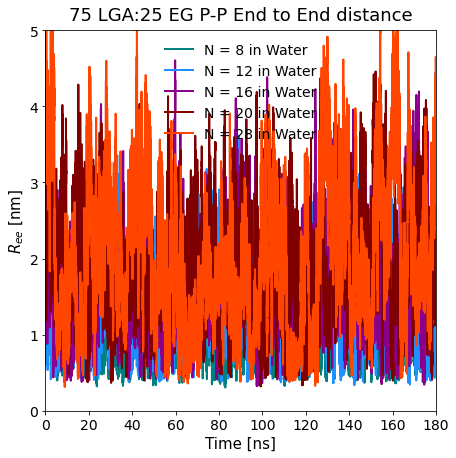

In [206]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P End to End distance', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{ee}$ [nm]', fontsize=15)
plt.plot(trj_len/100, e2edis_n8wat25LGA75EG[1]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, e2edis_n12wat25LGA75EG[1]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, e2edis_n16wat25LGA75EG[1]/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, e2edis_n20wat25LGA75EG[1]/10,linewidth=2, color='maroon')
plt.plot(trj_len/100, e2edis_n28wat25LGA75EG[1]/10,linewidth=2, color='orangered')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water'
            ,'N = 20 in Water','N = 28 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,5)

#### Ree Autocorrelation function

In [207]:
e2edis_n28wat25LGA75EG[1]

array([80.03384411, 83.12790893, 82.88155728, ..., 36.92877191,
       37.76231744, 40.20473689])

In [ ]:
t_corr = 2000
window_shift = 20

In [208]:
ACn28wat25LGA75EG_Ree, eqvar_n28wat25LGA75EG = obs_autocorr_RA(e2edis_n28wat25LGA75EG[1],t_corr, window_shift,start,end)

No. of Samples: 801


In [209]:
ACn28wat25LGA75EG_Ree

array([[1.00000000e+00, 9.93643245e-01, 9.49448406e-01, ...,
        1.47423688e-01, 1.39531230e-01, 1.80115849e-01],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        1.99700000e+03, 1.99800000e+03, 1.99900000e+03]])

In [210]:
eqvar_n28wat25LGA75EG

104.2764231045465

In [211]:
ACn28wat25LGA75EG_sqRee, evsqRee_n28wat25LGA75EG = obs_autocorr_RA(e2edis_n28wat25LGA75EG[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [212]:
np.sqrt(evsqRee_n28wat25LGA75EG)

540.9145233696015

(-1.0, 1.0)

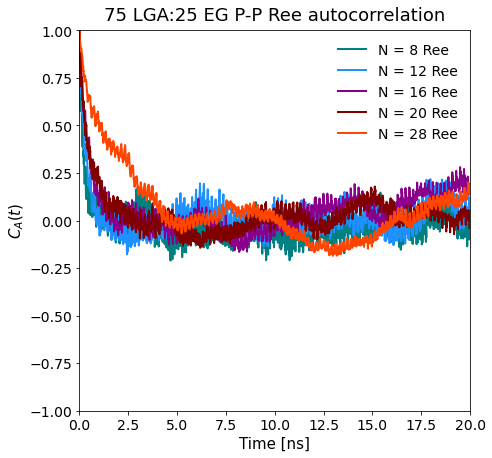

In [213]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Ree autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Ree[1]/100, ACn8wat25LGA75EG_Ree[0],linewidth=2, color='teal')
plt.plot(ACn12wat25LGA75EG_Ree[1]/100, ACn12wat25LGA75EG_Ree[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat25LGA75EG_Ree[1]/100, ACn16wat25LGA75EG_Ree[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat25LGA75EG_Ree[1]/100, ACn20wat25LGA75EG_Ree[0],linewidth=2, color='maroon')
plt.plot(ACn28wat25LGA75EG_Ree[1]/100, ACn28wat25LGA75EG_Ree[0],linewidth=2, color='orangered')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Ree','N = 12 Ree','N = 16 Ree','N = 20 Ree','N = 28 Ree'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

### Hydrodynamic Radius vs time

In [214]:
n28wat25LGA75EG_rh = hydro_rad_poly(n28wat_25LGA75EG, n28_25LGA_75EG_wat, n28_mon, start, end)

(0.0, 2.0)

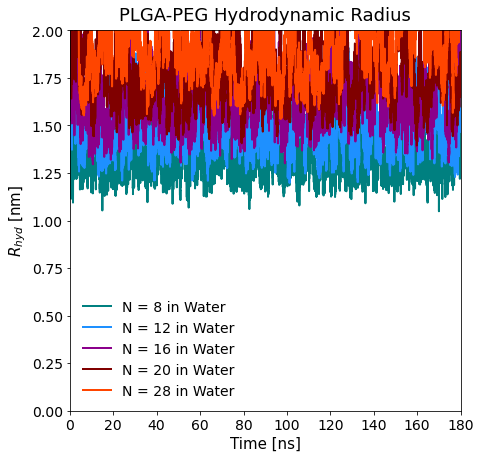

In [215]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA-PEG Hydrodynamic Radius', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{hyd}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n8wat25LGA75EG_rh/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n12wat25LGA75EG_rh/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n16wat25LGA75EG_rh/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, n20wat25LGA75EG_rh/10,linewidth=2, color='maroon')
plt.plot(trj_len/100, n28wat25LGA75EG_rh/10,linewidth=2, color='orangered')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water'
            ,'N = 20 in Water','N = 28 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,2)

#### Rh autocorrelation

In [216]:
ACn28wat25LGA75EG_Rh, eqvarRh_n28wat25LGA75EG = obs_autocorr_RA(n28wat25LGA75EG_rh,t_corr, window_shift,start,end)

No. of Samples: 801


In [217]:
ACn28wat25LGA75EG_Rh

array([[1.00000000e+00, 8.98022571e-01, 7.69378672e-01, ...,
        6.06371669e-01, 5.95005112e-01, 6.87584500e-01],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        1.99700000e+03, 1.99800000e+03, 1.99900000e+03]])

In [218]:
eqvarRh_n28wat25LGA75EG

4.172844327284736

(0.0, 20.0)

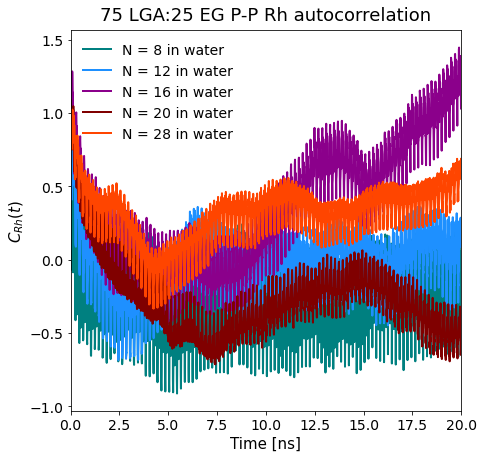

In [219]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Rh autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{Rh}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Rh[1]/100, ACn8wat25LGA75EG_Rh[0],linewidth=2, color='teal')
plt.plot(ACn12wat25LGA75EG_Rh[1]/100, ACn12wat25LGA75EG_Rh[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat25LGA75EG_Rh[1]/100, ACn16wat25LGA75EG_Rh[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat25LGA75EG_Rh[1]/100, ACn20wat25LGA75EG_Rh[0],linewidth=2, color='maroon')
plt.plot(ACn28wat25LGA75EG_Rh[1]/100, ACn28wat25LGA75EG_Rh[0],linewidth=2, color='orangered')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water', 'N = 12 in water','N = 16 in water'
            ,'N = 20 in water','N = 28 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,20)
#plt.ylim(-0.2,1)

### Radius of Gyration vs. time N = 28 25LGA:75EG in water

In [220]:
n2825LGA75EG_rgens_wat, cor_n2825LGA75EG_wat, n2825LGA75EG_cos_wat, rgwat_n2825LGA75EG = get_rg_pers_poly(n28wat_25LGA75EG, n28_25LGA_75EG_wat,
                                                                                                  start,end)

In [221]:
n2825LGA75EG_rgens_wat[0].shape

(18001,)

In [222]:
cor_n2825LGA75EG_wat[3]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26.])

In [223]:
n2825LGA75EG_cos_wat

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.91812316,  0.92685036,  0.93467391, ...,  0.86706679,
         0.87767517,  0.87196068],
       [ 0.85390606,  0.88353439,  0.89309261, ...,  0.6636428 ,
         0.67182185,  0.65510312],
       ...,
       [ 0.87808321,  0.85365622,  0.79319911, ..., -0.18831201,
        -0.28558964, -0.0933662 ],
       [ 0.80315719,  0.79484628,  0.73727771, ..., -0.1598318 ,
        -0.39787371,  0.05600279],
       [ 0.77295669,  0.72323324,  0.55627435, ...,  0.36734933,
         0.11594423,  0.5373776 ]])

In [224]:
rgwat_n2825LGA75EG

9.96169127274387

In [225]:
n2825LGA75EG_rgens_wat.shape

(2, 18001)

(0.2, 2.0)

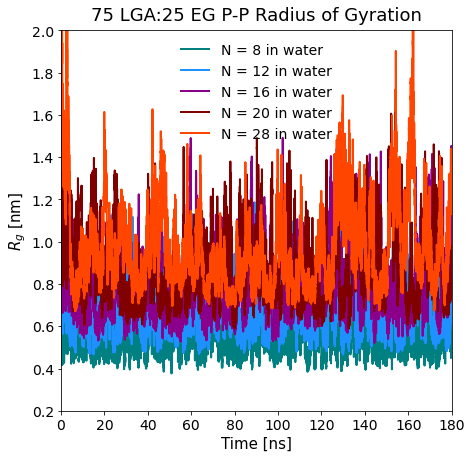

In [226]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n825LGA75EG_rgens_wat[0]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n1225LGA75EG_rgens_wat[0]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n1625LGA75EG_rgens_wat[0]/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, n2025LGA75EG_rgens_wat[0]/10,linewidth=2, color='maroon')
plt.plot(trj_len/100, n2825LGA75EG_rgens_wat[0]/10,linewidth=2, color='orangered')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water','N = 12 in water','N = 16 in water'
            ,'N = 20 in water','N = 28 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

#### Rg Autocorrelation

In [227]:
ACn28wat25LGA75EG_Rg, eqvarRg_n28wat25LGA75EG = obs_autocorr_RA(n2825LGA75EG_rgens_wat[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [228]:
ACn28wat25LGA75EG_Rg

array([[1.00000000e+00, 9.65418138e-01, 8.90773108e-01, ...,
        1.19739035e-01, 9.39908641e-02, 1.54769659e-01],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        1.99700000e+03, 1.99800000e+03, 1.99900000e+03]])

In [229]:
eqvarRg_n28wat25LGA75EG

4.4192070012502995

(-1.0, 1.0)

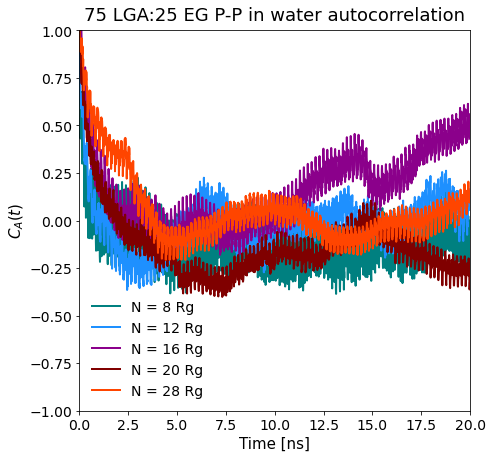

In [230]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P in water autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Rg[1]/100, ACn8wat25LGA75EG_Rg[0],linewidth=2, color='teal')
plt.plot(ACn12wat25LGA75EG_Rg[1]/100, ACn12wat25LGA75EG_Rg[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat25LGA75EG_Rg[1]/100, ACn16wat25LGA75EG_Rg[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat25LGA75EG_Rg[1]/100, ACn20wat25LGA75EG_Rg[0],linewidth=2, color='maroon')
plt.plot(ACn28wat25LGA75EG_Rg[1]/100, ACn28wat25LGA75EG_Rg[0],linewidth=2, color='orangered')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Rg','N = 12 Rg','N = 16 Rg','N = 20 Rg','N = 28 Rg'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

#### Get average COM distance, Arc length values

In [231]:
cb_n28plga = np.zeros(shape=(18001))
cb_n28pplinker = np.zeros(shape=(18001))
cb_n28peg = np.zeros(shape=(18001))
count = 0
for ts in n28_25LGA_75EG_wat.trajectory[0:18001]:
    # 1st two PLGA residues
    n28m1_plga = n28_25LGA_75EG_wat.select_atoms("resid 1")
    n28m2_plga = n28_25LGA_75EG_wat.select_atoms("resid 2")
    # PLGA-PEG linker
    n28pl_link = n28_25LGA_75EG_wat.select_atoms("resid 21")
    n28peg_link = n28_25LGA_75EG_wat.select_atoms("resid 22")
    # last two PEG residues 
    n28l1_peg = n28_25LGA_75EG_wat.select_atoms("resid 27")
    n28l2_peg = n28_25LGA_75EG_wat.select_atoms("resid 28")
    
    cb_n28plga[count] = mda.analysis.distances.distance_array(n28m1_plga.center_of_mass(), n28m2_plga.center_of_mass(), 
                                                   box=n28_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    cb_n28pplinker[count] = mda.analysis.distances.distance_array(n28pl_link.center_of_mass(), n28peg_link.center_of_mass(), 
                                                   box=n28_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    cb_n28peg[count] = mda.analysis.distances.distance_array(n28l1_peg.center_of_mass(), n28l2_peg.center_of_mass(), 
                                                   box=n28_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    count += 1
    

    

In [232]:
COM_n28pp = np.zeros(shape=(3,2))
COM_n28pp[0,0] = np.mean(cb_n28plga)
COM_n28pp[1,0] = np.mean(cb_n28pplinker)
COM_n28pp[2,0] = np.mean(cb_n28peg)
COM_n28pp[0,1] = np.std(cb_n28plga)
COM_n28pp[1,1] = np.std(cb_n28pplinker)
COM_n28pp[2,1] = np.std(cb_n28peg)
COM_n28pp

array([[5.41442077, 0.7265877 ],
       [3.2554083 , 0.15122085],
       [3.24368011, 0.15136192]])

#### Correlation values at each arc length from the whole 360 ns trajectory, N = 28 25LGA:75EG/water

In [233]:
# x values
blen_n28pp = np.zeros(shape=n28_mon-1)
for i in range(n28_mon-1):
    if i < int(n28_mon-21):
        # PLGA contour length values
        if i == 0:
            blen_n28pp[i] = 0
        elif i != 0:
            blen_n28pp[i] = np.sum(blen_n28pp[i-1])+ COM_n28pp[0,0]    
    elif i == int(n28_mon-21):
        #PLGA-PEG linker length
        blen_n28pp[i] = np.sum(blen_n28pp[i-1]) + COM_n28pp[1,0]
    elif i > int(n28_mon-21):
    #    # PEG contour length values
        blen_n28pp[i] = np.sum(blen_n28pp[i-1]) + COM_n28pp[2,0]
        
blen_n28pp

array([ 0.        ,  5.41442077, 10.82884154, 16.24326232, 21.65768309,
       27.07210386, 32.48652463, 35.74193293, 38.98561304, 42.22929315,
       45.47297326, 48.71665337, 51.96033348, 55.20401359, 58.4476937 ,
       61.69137381, 64.93505392, 68.17873403, 71.42241414, 74.66609425,
       77.90977436, 81.15345447, 84.39713458, 87.64081469, 90.8844948 ,
       94.12817491, 97.37185502])

In [234]:
# Error prop. into natural log std deviation
mk_n28ppwat = cor_n2825LGA75EG_wat[1]/cor_n2825LGA75EG_wat[0]
mk_n28ppwat

array([0.        , 0.00285819, 0.01006265, 0.02129585, 0.03304321,
       0.04332902, 0.05648174, 0.06835574, 0.07898683, 0.08855836,
       0.10198898, 0.1162588 , 0.12280758, 0.13158505, 0.14518363,
       0.16618782, 0.18476987, 0.19040946, 0.18194758, 0.17542821,
       0.18909517, 0.20289974, 0.25001834, 0.31500987, 0.36152827,
       0.42147196, 0.66740456])

<ErrorbarContainer object of 3 artists>

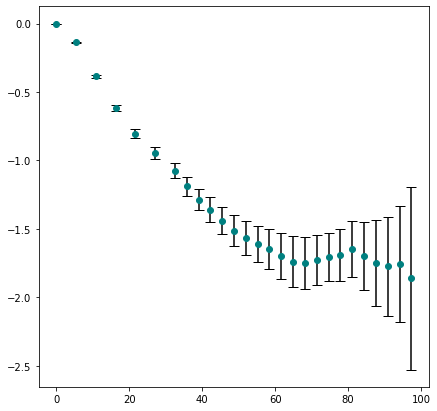

In [235]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_n28pp, np.log(cor_n2825LGA75EG_wat[0]), yerr=mk_n28ppwat, color='teal', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [236]:
# All the points give the best fits for N = 6 peg in water
n28_blks25LGA75EG_wat , n2825LGA75EG_lpwat = bavg_pers_cnt(5, n28wat_25LGA75EG, n28_25LGA_75EG_wat, blen_n28pp, 3, start, end)

0
3600
[1.         0.87465707 0.6932918  0.55340749 0.46296857 0.40457635
 0.35975549 0.32160522 0.29182202 0.26764439 0.24082571 0.21435917
 0.1973054  0.18885775 0.18234658 0.17846494 0.17222763 0.1722167
 0.18929119 0.22036291 0.24923031 0.27613596 0.2933162  0.29541387
 0.29377135 0.23733243 0.1444128 ]
Lp [Angstroms]: 29.562419793615756
Error in Lp from fit [Angstroms], 95% CL : 58.291082070527644
R2 score: 0.9764843036361659
3600
7200
[1.         0.87267832 0.68178026 0.54206114 0.45390701 0.40482514
 0.35882341 0.31667552 0.28613125 0.26079995 0.23426549 0.21279432
 0.19839697 0.19271502 0.18367479 0.17105173 0.16522146 0.16832575
 0.17394181 0.18097082 0.18813745 0.22002619 0.23951873 0.23495807
 0.25113645 0.22273194 0.23748399]
Lp [Angstroms]: 28.270204384805773
Error in Lp from fit [Angstroms], 95% CL : 59.919230021703555
R2 score: 0.9729278050604793
7200
10800
[1.         0.87387029 0.67963155 0.52836826 0.42530149 0.34723153
 0.27899784 0.23193165 0.19969855 0.1782748  0.1

In [237]:
n28_blks25LGA75EG_wat

{'Avg Hydrodynamic radius': array([19.34001809665668, 19.086086133372014, 18.18741704617668,
        19.575302865280136, 19.966775787844277], dtype=object),
 'Avg Radius of gyration': array([10.40451785,  9.66714494,  8.72993953, 10.24124378, 10.64658008]),
 'Avg Sq. radius of gyration': array([108.25399172,  93.45369126,  76.21184415, 104.88307417,
        113.34966737]),
 'Avg end to end distance': array([24.99619387, 21.21788348, 19.19119062, 22.67810077, 25.46171814]),
 'Avg Sq. end to end distance': array([624.80970802, 450.19857918, 368.3017976 , 514.29625444,
        648.29909084]),
 'Avg persistence length': array([29.56241979, 28.27020438, 28.03914164, 27.80754903, 27.13495525])}

In [238]:
n2825LGA75EG_lpwat

array([[ 2.95624198e+01,  2.82702044e+01,  2.80391416e+01,
         2.78075490e+01,  2.71349552e+01],
       [ 5.82910821e+01,  5.99192300e+01,  6.20789038e+01,
         6.02063355e+01,  5.82930259e+01],
       [-3.38267303e-02, -3.53729314e-02, -3.56644298e-02,
        -3.59614578e-02, -3.68528340e-02],
       [ 1.61564752e-03,  2.04135698e-03,  2.26428727e-03,
         2.20158697e-03,  2.27624531e-03]])

In [239]:
n2825LGA75EG_lpwat[2]

array([-0.03382673, -0.03537293, -0.03566443, -0.03596146, -0.03685283])

In [240]:
np.mean(n2825LGA75EG_lpwat[3])

0.0020798248117867815

#### Block averaged Radius of gyration and persistence length, N = 28 25LGA:75EG/water

In [241]:
np.mean(n28_blks25LGA75EG_wat["Avg Radius of gyration"])

9.937885235246643

In [242]:
np.std(n28_blks25LGA75EG_wat["Avg Radius of gyration"])

0.6847560043980652

In [243]:
rg25LGA75EG_olig_wat[r"$R_{g}$ [Angstrom] N = 28 25LGA:75EG water"] = n28_blks25LGA75EG_wat["Avg Radius of gyration"]
rg25LGA75EG_olig_wat

,$R_{g}$ [Angstrom] N = 8 25LGA:75EG water,$R_{g}$ [Angstrom] N = 12 25LGA:75EG water,$R_{g}$ [Angstrom] N = 16 25LGA:75EG water,$R_{g}$ [Angstrom] N = 20 25LGA:75EG water,$R_{g}$ [Angstrom] N = 28 25LGA:75EG water
0,5.640842,7.033425,7.780369,9.138295,10.404518
1,5.883404,6.760528,7.628486,8.393087,9.667145
2,5.671338,7.084498,8.211754,9.160664,8.729940
3,5.794893,6.925734,8.430307,8.685515,10.241244
4,5.609840,6.980828,8.298279,9.507016,10.646580


In [244]:
pers_25LGA75EG_wat[r"$L_{p}$ [Angstrom] N = 28 25LGA:75EG water"] = n28_blks25LGA75EG_wat["Avg persistence length"]
pers_25LGA75EG_wat

,$L_{p}$ [Angstrom] N = 8 25LGA:75EG water,$L_{p}$ [Angstrom] N = 12 25LGA:75EG water,$L_{p}$ [Angstrom] N = 16 25LGA:75EG water,$L_{p}$ [Angstrom] N = 20 25LGA:75EG water,$L_{p}$ [Angstrom] N = 28 25LGA:75EG water
0,26.173662,28.236197,26.685612,28.487180,29.562420
1,27.191520,26.175339,27.432595,28.319258,28.270204
2,26.357982,27.918997,27.909315,29.764118,28.039142
3,26.336082,29.067837,29.731576,28.245280,27.807549
4,26.082105,29.667237,30.550526,28.712613,27.134955


### N = 32 25LGA:75EG in water

In [245]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n32_25LGA_75EG_wat = mda.Universe("n3225LGA_75EG/n3225LGA75EG_WAT.pdb", "n3225LGA_75EG/NoWat_n3225LGA_75EG.xtc")

In [246]:
n32_25LGA_75EG_wat.trajectory

<XTCReader n3225LGA_75EG/NoWat_n3225LGA_75EG.xtc with 18001 frames of 291 atoms>

In [247]:
len(n32_25LGA_75EG_wat.trajectory)

18001

In [248]:
#Select the polymer heavy atoms 
n32wat_25LGA75EG = n32_25LGA_75EG_wat.select_atoms("resname sPLG PLG bPLG bPEG PEG sPEG and not type H")

In [249]:
np.unique(n32wat_25LGA75EG.resids)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [250]:
# Get cosine theta values at frame 0 
crv_n32wat_25LGA75EG = pers_length(n32wat_25LGA75EG,32)
crv_n32wat_25LGA75EG

array([[ 1.        ,  0.93988145,  0.96153707,  0.93072327,  0.94668941,
         0.9276695 ,  0.93598908,  0.92050566,  0.9294869 ,  0.91837442,
         0.92123978,  0.9086538 ,  0.912633  ,  0.90315568,  0.9003394 ,
         0.89511727,  0.89138657,  0.88012888,  0.87582476,  0.86296282,
         0.86343026,  0.8587977 ,  0.84516891,  0.8282513 ,  0.87204998,
         0.89758905,  0.89706868,  0.90591221,  0.90671534,  0.91401395,
         0.90625392],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        , 11.        , 12.        , 13.        , 14.        ,
        15.        , 16.        , 17.        , 18.        , 19.        ,
        20.        , 21.        , 22.        , 23.        , 24.        ,
        25.        , 26.        , 27.        , 28.        , 29.        ,
        30.        ],
       [ 0.        , 19.96834288, 15.94265844, 21.45215876, 18.7928606 ,
       

### Mean squared end to end distance 

In [251]:
n32_mon = 32
start = 0
end = 18001
trj_len = np.arange(18001)

In [252]:
eVec_n32wat25LGA75EG, e2edis_n32wat25LGA75EG = mean_sq_e2e(n32wat_25LGA75EG, n32_25LGA_75EG_wat, n32_mon, start, end)

(0.0, 12.0)

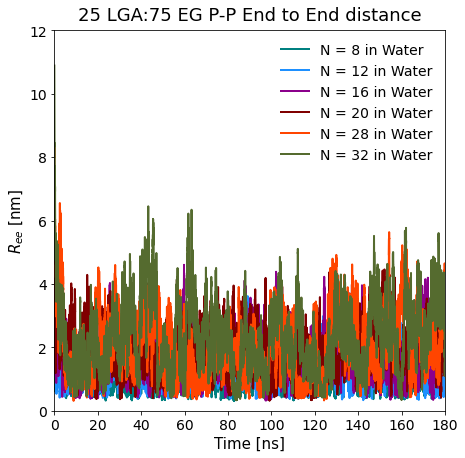

In [316]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P End to End distance', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{ee}$ [nm]', fontsize=15)
plt.plot(trj_len/100, e2edis_n8wat25LGA75EG[1]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, e2edis_n12wat25LGA75EG[1]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, e2edis_n16wat25LGA75EG[1]/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, e2edis_n20wat25LGA75EG[1]/10,linewidth=2, color='maroon')
plt.plot(trj_len/100, e2edis_n28wat25LGA75EG[1]/10,linewidth=2, color='orangered')
plt.plot(trj_len/100, e2edis_n32wat25LGA75EG[1]/10,linewidth=2, color='darkolivegreen')
plt.tick_params(labelsize=14)
#plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water'], frameon=False, fontsize=14)
#plt.legend(['N = 20 in Water','N = 28 in Water','N = 32 in Water'], frameon=False, fontsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water'
            ,'N = 20 in Water','N = 28 in Water','N = 32 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,12)

In [254]:
np.save('n8_25LGA75EG_ReeWAT.npy',e2edis_n8wat25LGA75EG)
np.save('n12_25LGA75EG_ReeWAT.npy',e2edis_n12wat25LGA75EG)
np.save('n16_25LGA75EG_ReeWAT.npy',e2edis_n16wat25LGA75EG)
np.save('n20_25LGA75EG_ReeWAT.npy',e2edis_n20wat25LGA75EG)
np.save('n28_25LGA75EG_ReeWAT.npy',e2edis_n28wat25LGA75EG)
np.save('n32_25LGA75EG_ReeWAT.npy',e2edis_n32wat25LGA75EG)

#### Ree Autocorrelation function

In [255]:
e2edis_n32wat25LGA75EG[1]

array([108.8704296 , 107.01162082, 103.40454286, ...,  13.15802081,
        12.82320692,  14.71867893])

In [256]:
t_corr = 2000
window_shift = 20

In [257]:
ACn32wat25LGA75EG_Ree, eqvar_n32wat25LGA75EG = obs_autocorr_RA(e2edis_n32wat25LGA75EG[1],t_corr, window_shift,start,end)

No. of Samples: 801


In [258]:
ACn32wat25LGA75EG_Ree

array([[1.00000000e+00, 9.74761757e-01, 9.56264529e-01, ...,
        6.02686176e-02, 8.28493850e-02, 8.73273088e-02],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        1.99700000e+03, 1.99800000e+03, 1.99900000e+03]])

In [259]:
eqvar_n32wat25LGA75EG

128.0894509771183

In [260]:
ACn32wat25LGA75EG_sqRee, evsqRee_n32wat25LGA75EG = obs_autocorr_RA(e2edis_n32wat25LGA75EG[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [261]:
np.sqrt(evsqRee_n32wat25LGA75EG)

719.3528472370973

(-1.0, 1.0)

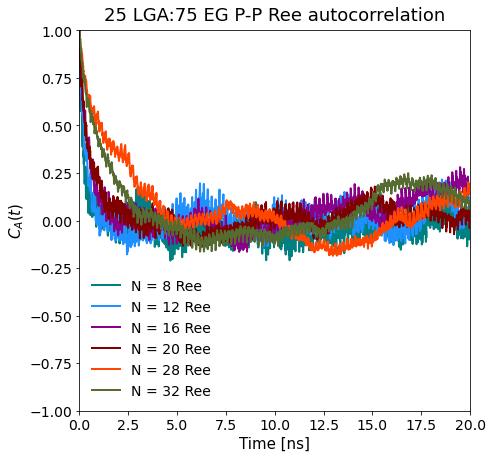

In [317]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Ree autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Ree[1]/100, ACn8wat25LGA75EG_Ree[0],linewidth=2, color='teal')
plt.plot(ACn12wat25LGA75EG_Ree[1]/100, ACn12wat25LGA75EG_Ree[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat25LGA75EG_Ree[1]/100, ACn16wat25LGA75EG_Ree[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat25LGA75EG_Ree[1]/100, ACn20wat25LGA75EG_Ree[0],linewidth=2, color='maroon')
plt.plot(ACn28wat25LGA75EG_Ree[1]/100, ACn28wat25LGA75EG_Ree[0],linewidth=2, color='orangered')
plt.plot(ACn32wat25LGA75EG_Ree[1]/100, ACn32wat25LGA75EG_Ree[0],linewidth=2, color='darkolivegreen')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Ree','N = 12 Ree','N = 16 Ree','N = 20 Ree','N = 28 Ree','N = 32 Ree'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

### Hydrodynamic Radius vs time

In [263]:
n32wat25LGA75EG_rh = hydro_rad_poly(n32wat_25LGA75EG, n32_25LGA_75EG_wat, n32_mon, start, end)

(0.0, 6.0)

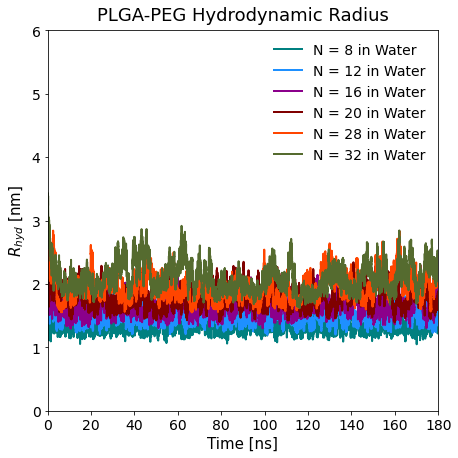

In [319]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA-PEG Hydrodynamic Radius', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{hyd}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n8wat25LGA75EG_rh/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n12wat25LGA75EG_rh/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n16wat25LGA75EG_rh/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, n20wat25LGA75EG_rh/10,linewidth=2, color='maroon')
plt.plot(trj_len/100, n28wat25LGA75EG_rh/10,linewidth=2, color='orangered')
plt.plot(trj_len/100, n32wat25LGA75EG_rh/10,linewidth=2, color='darkolivegreen')
plt.tick_params(labelsize=14)
#plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water'], frameon=False, fontsize=14)
#plt.legend(['N = 20 in Water','N = 28 in Water','N = 32 in Water'], frameon=False, fontsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water'
            ,'N = 20 in Water','N = 28 in Water','N = 32 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,6)

In [265]:
np.save('n8_25LGA75EG_RHYDwat.npy',n8wat25LGA75EG_rh)
np.save('n12_25LGA75EG_RHYDwat.npy',n12wat25LGA75EG_rh)
np.save('n16_25LGA75EG_RHYDwat.npy',n16wat25LGA75EG_rh)
np.save('n20_25LGA75EG_RHYDwat.npy',n20wat25LGA75EG_rh)
np.save('n28_25LGA75EG_RHYDwat.npy',n28wat25LGA75EG_rh)
np.save('n32_25LGA75EG_RHYDwat.npy',n32wat25LGA75EG_rh)

#### Rh autocorrelation

In [266]:
ACn32wat25LGA75EG_Rh, eqvarRh_n32wat25LGA75EG = obs_autocorr_RA(n32wat25LGA75EG_rh,t_corr, window_shift,start,end)

No. of Samples: 801


In [267]:
ACn32wat25LGA75EG_Rh

array([[1.00000000e+00, 9.51523233e-01, 9.74394967e-01, ...,
        4.54450796e-01, 5.19947383e-01, 4.75126407e-01],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        1.99700000e+03, 1.99800000e+03, 1.99900000e+03]])

In [268]:
eqvarRh_n32wat25LGA75EG

5.247639864577309

(-1.0, 2.0)

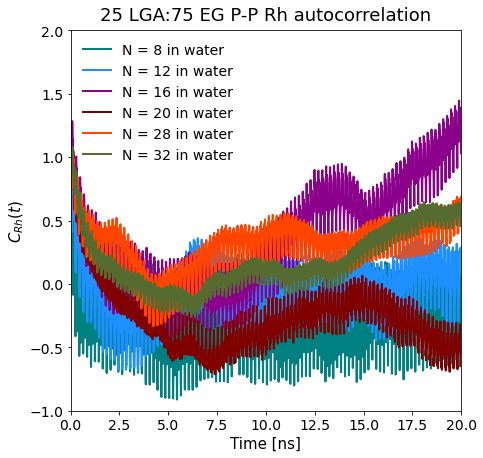

In [320]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Rh autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{Rh}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Rh[1]/100, ACn8wat25LGA75EG_Rh[0],linewidth=2, color='teal')
plt.plot(ACn12wat25LGA75EG_Rh[1]/100, ACn12wat25LGA75EG_Rh[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat25LGA75EG_Rh[1]/100, ACn16wat25LGA75EG_Rh[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat25LGA75EG_Rh[1]/100, ACn20wat25LGA75EG_Rh[0],linewidth=2, color='maroon')
plt.plot(ACn28wat25LGA75EG_Rh[1]/100, ACn28wat25LGA75EG_Rh[0],linewidth=2, color='orangered')
plt.plot(ACn32wat25LGA75EG_Rh[1]/100, ACn32wat25LGA75EG_Rh[0],linewidth=2, color='darkolivegreen')
plt.tick_params(labelsize=14)
#plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water'], frameon=False, fontsize=14)
#plt.legend(['N = 20 in Water','N = 28 in Water','N = 32 in Water'], frameon=False, fontsize=14)
plt.legend(['N = 8 in water', 'N = 12 in water','N = 16 in water'
            ,'N = 20 in water','N = 28 in water','N = 32 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,20)
plt.ylim(-1,2)

### Radius of Gyration vs. time N = 32 25LGA:75EG in water

In [270]:
n3225LGA75EG_rgens_wat, cor_n3225LGA75EG_wat, n3225LGA75EG_cos_wat, rgwat_n3225LGA75EG = get_rg_pers_poly(n32wat_25LGA75EG, n32_25LGA_75EG_wat,
                                                                                                  start,end)

In [271]:
n3225LGA75EG_rgens_wat[0].shape

(18001,)

In [272]:
cor_n3225LGA75EG_wat[3]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30.])

In [273]:
n3225LGA75EG_cos_wat

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.93988145,  0.94404785,  0.94331239, ...,  0.86497005,
         0.86610148,  0.85521405],
       [ 0.96153707,  0.94358187,  0.94190031, ...,  0.71122275,
         0.7140142 ,  0.68981836],
       ...,
       [ 0.90671534,  0.94549254,  0.95113233, ...,  0.03573952,
         0.25225646,  0.47782571],
       [ 0.91401395,  0.95347117,  0.93940834, ...,  0.29119551,
         0.50628959,  0.60008828],
       [ 0.90625392,  0.9773994 ,  0.90269531, ..., -0.17169711,
         0.22732636,  0.67978295]])

In [274]:
rgwat_n3225LGA75EG

11.017490221827817

In [275]:
n3225LGA75EG_rgens_wat.shape

(2, 18001)

(0.2, 4.0)

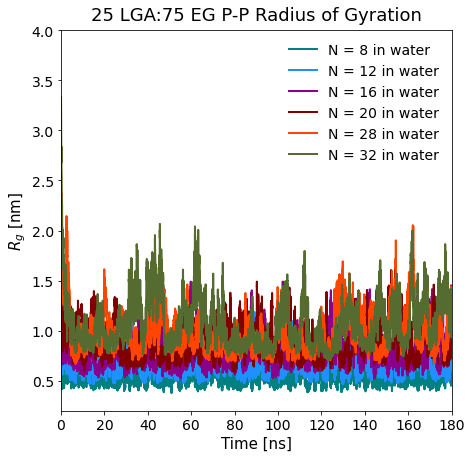

In [322]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n825LGA75EG_rgens_wat[0]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n1225LGA75EG_rgens_wat[0]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n1625LGA75EG_rgens_wat[0]/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, n2025LGA75EG_rgens_wat[0]/10,linewidth=2, color='maroon')
plt.plot(trj_len/100, n2825LGA75EG_rgens_wat[0]/10,linewidth=2, color='orangered')
plt.plot(trj_len/100, n3225LGA75EG_rgens_wat[0]/10,linewidth=2, color='darkolivegreen')
plt.tick_params(labelsize=14)
#plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water'], frameon=False, fontsize=14)
#plt.legend(['N = 20 in Water','N = 28 in Water','N = 32 in Water'], frameon=False, fontsize=14)
plt.legend(['N = 8 in water','N = 12 in water','N = 16 in water'
            ,'N = 20 in water','N = 28 in water','N = 32 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,4)

In [277]:
np.save('n8_25LGA75EG_Rgwat.npy',n825LGA75EG_rgens_wat)
np.save('n12_25LGA75EG_Rgwat.npy',n1225LGA75EG_rgens_wat)
np.save('n16_25LGA75EG_Rgwat.npy',n1625LGA75EG_rgens_wat)
np.save('n20_25LGA75EG_Rgwat.npy',n2025LGA75EG_rgens_wat)
np.save('n28_25LGA75EG_Rgwat.npy',n2825LGA75EG_rgens_wat)
np.save('n32_25LGA75EG_Rgwat.npy',n3225LGA75EG_rgens_wat)

#### Rg Autocorrelation

In [278]:
ACn32wat25LGA75EG_Rg, eqvarRg_n32wat25LGA75EG = obs_autocorr_RA(n3225LGA75EG_rgens_wat[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [279]:
ACn32wat25LGA75EG_Rg

array([[1.00000000e+00, 9.74003197e-01, 9.69163431e-01, ...,
        2.18079732e-01, 2.29332975e-01, 2.15370350e-01],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        1.99700000e+03, 1.99800000e+03, 1.99900000e+03]])

In [280]:
eqvarRg_n32wat25LGA75EG

6.494576757225573

(-1.0, 1.5)

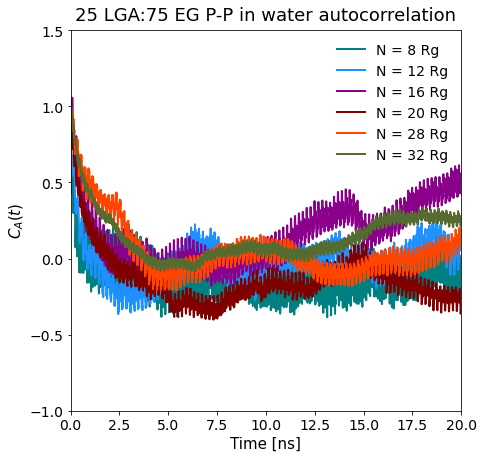

In [327]:
plt.figure(figsize=(7,7))
plt.title(r'25 LGA:75 EG P-P in water autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat25LGA75EG_Rg[1]/100, ACn8wat25LGA75EG_Rg[0],linewidth=2, color='teal')
plt.plot(ACn12wat25LGA75EG_Rg[1]/100, ACn12wat25LGA75EG_Rg[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat25LGA75EG_Rg[1]/100, ACn16wat25LGA75EG_Rg[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat25LGA75EG_Rg[1]/100, ACn20wat25LGA75EG_Rg[0],linewidth=2, color='maroon')
plt.plot(ACn28wat25LGA75EG_Rg[1]/100, ACn28wat25LGA75EG_Rg[0],linewidth=2, color='orangered')
plt.plot(ACn32wat25LGA75EG_Rg[1]/100, ACn32wat25LGA75EG_Rg[0],linewidth=2, color='darkolivegreen')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Rg','N = 12 Rg','N = 16 Rg','N = 20 Rg','N = 28 Rg','N = 32 Rg'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1.5)

#### Get average COM distance, Arc length values

In [282]:
cb_n32plga = np.zeros(shape=(18001))
cb_n32pplinker = np.zeros(shape=(18001))
cb_n32peg = np.zeros(shape=(18001))
count = 0
for ts in n32_25LGA_75EG_wat.trajectory[0:18001]:
    # 1st two PLGA residues
    n32m1_plga = n32_25LGA_75EG_wat.select_atoms("resid 1")
    n32m2_plga = n32_25LGA_75EG_wat.select_atoms("resid 2")
    # PLGA-PEG linker
    n32pl_link = n32_25LGA_75EG_wat.select_atoms("resid 23")
    n32peg_link = n32_25LGA_75EG_wat.select_atoms("resid 24")
    # last two PEG residues 
    n32l1_peg = n32_25LGA_75EG_wat.select_atoms("resid 31")
    n32l2_peg = n32_25LGA_75EG_wat.select_atoms("resid 32")
    
    cb_n32plga[count] = mda.analysis.distances.distance_array(n32m1_plga.center_of_mass(), n32m2_plga.center_of_mass(), 
                                                   box=n32_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    cb_n32pplinker[count] = mda.analysis.distances.distance_array(n32pl_link.center_of_mass(), n32peg_link.center_of_mass(), 
                                                   box=n32_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    cb_n32peg[count] = mda.analysis.distances.distance_array(n32l1_peg.center_of_mass(), n32l2_peg.center_of_mass(), 
                                                   box=n32_25LGA_75EG_wat.trajectory.ts.dimensions)
    
    count += 1
    

    

In [283]:
COM_n32pp = np.zeros(shape=(3,2))
COM_n32pp[0,0] = np.mean(cb_n32plga)
COM_n32pp[1,0] = np.mean(cb_n32pplinker)
COM_n32pp[2,0] = np.mean(cb_n32peg)
COM_n32pp[0,1] = np.std(cb_n32plga)
COM_n32pp[1,1] = np.std(cb_n32pplinker)
COM_n32pp[2,1] = np.std(cb_n32peg)
COM_n32pp

array([[5.61017779, 0.75860535],
       [3.25032726, 0.15582179],
       [3.24258893, 0.15397432]])

#### Correlation values at each arc length from the whole 360 ns trajectory, N = 32 25LGA:75EG/water

In [284]:
# x values
blen_n32pp = np.zeros(shape=n32_mon-1)
for i in range(n32_mon-1):
    if i < int(n32_mon-24):
        # PLGA contour length values
        if i == 0:
            blen_n32pp[i] = 0
        elif i != 0:
            blen_n32pp[i] = np.sum(blen_n32pp[i-1])+ COM_n32pp[0,0]    
    elif i == int(n32_mon-24):
        #PLGA-PEG linker length
        blen_n32pp[i] = np.sum(blen_n32pp[i-1]) + COM_n32pp[1,0]
    elif i > int(n32_mon-24):
    #    # PEG contour length values
        blen_n32pp[i] = np.sum(blen_n32pp[i-1]) + COM_n32pp[2,0]
        
blen_n32pp

array([  0.        ,   5.61017779,  11.22035558,  16.83053336,
        22.44071115,  28.05088894,  33.66106673,  39.27124451,
        42.52157178,  45.7641607 ,  49.00674963,  52.24933856,
        55.49192749,  58.73451642,  61.97710535,  65.21969427,
        68.4622832 ,  71.70487213,  74.94746106,  78.19004999,
        81.43263892,  84.67522785,  87.91781677,  91.1604057 ,
        94.40299463,  97.64558356, 100.88817249, 104.13076142,
       107.37335034, 110.61593927, 113.8585282 ])

In [285]:
# Error prop. into natural log std deviation
mk_n32ppwat = cor_n3225LGA75EG_wat[1]/cor_n3225LGA75EG_wat[0]
mk_n32ppwat

array([0.        , 0.0025583 , 0.00935676, 0.02007335, 0.0293128 ,
       0.03723639, 0.04439481, 0.05325895, 0.06328574, 0.07277205,
       0.08099363, 0.08841606, 0.09687875, 0.11225131, 0.12735753,
       0.1395662 , 0.15106192, 0.16281594, 0.17485267, 0.19160179,
       0.20929783, 0.2099795 , 0.20498641, 0.20113855, 0.20578189,
       0.2477903 , 0.25482083, 0.29398355, 0.4017257 , 0.52596557,
       0.56405775])

<ErrorbarContainer object of 3 artists>

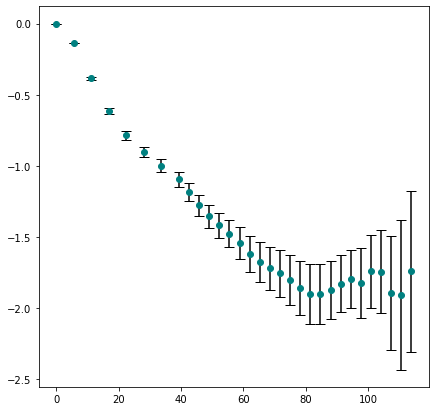

In [286]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_n32pp, np.log(cor_n3225LGA75EG_wat[0]), yerr=mk_n32ppwat, color='teal', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [287]:
# All the points give the best fits for N = 6 peg in water
n32_blks25LGA75EG_wat , n3225LGA75EG_lpwat = bavg_pers_cnt(5, n32wat_25LGA75EG, n32_25LGA_75EG_wat, blen_n32pp, 3, start, end)

0
3600
[1.         0.87543505 0.68890532 0.55751966 0.47302231 0.4168691
 0.36923332 0.33022075 0.29857831 0.2714216  0.24969513 0.23413266
 0.22080305 0.20808819 0.19142701 0.1727865  0.15696896 0.1421215
 0.13071344 0.11709084 0.10552148 0.09868053 0.09612422 0.09706463
 0.08999642 0.07862552 0.09428407 0.09305296 0.05304909 0.06136558
 0.0768425 ]
Lp [Angstroms]: 30.10951948861439
Error in Lp from fit [Angstroms], 95% CL : 63.17473098225755
R2 score: 0.9734561539323756
3600
7200
[1.         0.87556292 0.68776316 0.55078398 0.46419278 0.41488025
 0.38715885 0.36393771 0.34214037 0.32260595 0.30692472 0.29166892
 0.27720399 0.26328373 0.25047806 0.24372561 0.24113916 0.23623195
 0.22496522 0.20924762 0.19507551 0.18544235 0.17976276 0.17669636
 0.16590993 0.13336848 0.12823229 0.13337227 0.12289227 0.13851378
 0.09395125]
Lp [Angstroms]: 29.97604490687816
Error in Lp from fit [Angstroms], 95% CL : 63.76229612294717
R2 score: 0.9727388728588682
7200
10800
[1.         0.87011826 0.67490

In [288]:
n32_blks25LGA75EG_wat

{'Avg Hydrodynamic radius': array([20.948876920831776, 21.73650951189665, 19.929598354250828,
        19.698998222777387, 21.54472041505562], dtype=object),
 'Avg Radius of gyration': array([11.17579255, 12.1910608 ,  9.72141878,  9.90078294, 11.86938845]),
 'Avg Sq. radius of gyration': array([124.89833902, 148.62196337,  94.50598304,  98.02550284,
        140.88238212]),
 'Avg end to end distance': array([25.20212187, 29.1877509 , 22.12888482, 20.92131083, 30.26574631]),
 'Avg Sq. end to end distance': array([635.14694657, 851.92480259, 489.68754328, 437.70124684,
        916.01539998]),
 'Avg persistence length': array([30.10951949, 29.97604491, 28.53700223, 28.60785232, 28.56985473])}

In [289]:
n3225LGA75EG_lpwat

array([[ 3.01095195e+01,  2.99760449e+01,  2.85370022e+01,
         2.86078523e+01,  2.85698547e+01],
       [ 6.31747310e+01,  6.37622961e+01,  6.11946587e+01,
         6.14767917e+01,  6.44257801e+01],
       [-3.32120876e-02, -3.33599714e-02, -3.50422231e-02,
        -3.49554377e-02, -3.50019281e-02],
       [ 1.89331576e-03,  1.96327944e-03,  2.20163430e-03,
         2.20005184e-03,  2.42906306e-03]])

In [290]:
n3225LGA75EG_lpwat[2]

array([-0.03321209, -0.03335997, -0.03504222, -0.03495544, -0.03500193])

In [291]:
np.mean(n3225LGA75EG_lpwat[3])

0.00213746888296042

#### Block averaged Radius of gyration and persistence length, N = 32 25LGA:75EG/water

In [292]:
np.mean(n32_blks25LGA75EG_wat["Avg Radius of gyration"])

10.971688701716937

In [293]:
np.std(n32_blks25LGA75EG_wat["Avg Radius of gyration"])

1.004430739630558

In [294]:
rg25LGA75EG_olig_wat[r"$R_{g}$ [Angstrom] N = 32 25LGA:75EG water"] = n32_blks25LGA75EG_wat["Avg Radius of gyration"]
rg25LGA75EG_olig_wat

,$R_{g}$ [Angstrom] N = 8 25LGA:75EG water,$R_{g}$ [Angstrom] N = 12 25LGA:75EG water,$R_{g}$ [Angstrom] N = 16 25LGA:75EG water,$R_{g}$ [Angstrom] N = 20 25LGA:75EG water,$R_{g}$ [Angstrom] N = 28 25LGA:75EG water,$R_{g}$ [Angstrom] N = 32 25LGA:75EG water
0,5.640842,7.033425,7.780369,9.138295,10.404518,11.175793
1,5.883404,6.760528,7.628486,8.393087,9.667145,12.191061
2,5.671338,7.084498,8.211754,9.160664,8.729940,9.721419
3,5.794893,6.925734,8.430307,8.685515,10.241244,9.900783
4,5.609840,6.980828,8.298279,9.507016,10.646580,11.869388


In [295]:
pers_25LGA75EG_wat[r"$L_{p}$ [Angstrom] N = 32 25LGA:75EG water"] = n32_blks25LGA75EG_wat["Avg persistence length"]
pers_25LGA75EG_wat

,$L_{p}$ [Angstrom] N = 8 25LGA:75EG water,$L_{p}$ [Angstrom] N = 12 25LGA:75EG water,$L_{p}$ [Angstrom] N = 16 25LGA:75EG water,$L_{p}$ [Angstrom] N = 20 25LGA:75EG water,$L_{p}$ [Angstrom] N = 28 25LGA:75EG water,$L_{p}$ [Angstrom] N = 32 25LGA:75EG water
0,26.173662,28.236197,26.685612,28.487180,29.562420,30.109519
1,27.191520,26.175339,27.432595,28.319258,28.270204,29.976045
2,26.357982,27.918997,27.909315,29.764118,28.039142,28.537002
3,26.336082,29.067837,29.731576,28.245280,27.807549,28.607852
4,26.082105,29.667237,30.550526,28.712613,27.134955,28.569855


In [296]:
rg25LGA75EG_olig_wat.to_pickle("25LGA75EG_wat_Rg.pkl")

In [ ]:
pers_plgapegt_wat.to_pickle("25LGA75EG_wat_Lp.pkl")